# **0. Importación de <ins>librerías</ins> y <ins>carga de archivos</ins>**

In [1]:
## IMPORTACIÓN DE LIBRERÍAS

import pandas as pd # Pandas
import matplotlib.pyplot as plt # Matplorlib
import matplotlib.colors as mcolors # Matplorlib
import matplotlib.dates as mdates
#from dateutil.relativedelta import relativedelta # Dates
#import seaborn as sns #Seaborn
import numpy as np #Numpy
from matplotlib.colors import LinearSegmentedColormap #Paleta de colores
import pycaret
from pycaret.regression import *
from prophet import Prophet
from pycaret.regression import save_model
from pycaret.regression import load_model
# Desactivamos Warnings
#import warnings
#warnings.filterwarnings('ignore')
from pycaret.regression import setup, compare_models
from sklearn.model_selection import TimeSeriesSplit

from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from pycaret.regression import predict_model
from multiprocessing import Pool, cpu_count
#from pycaret.time_series import TSForecastingExperiment

from datetime import datetime


In [210]:
# Cargar los archivos
df_merged = pd.read_csv('df_merged_original.csv')
df_merged_last_prices = pd.read_csv('df_merged_last_prices.csv')

# **1. <ins>Transformación</ins> del Dataframe**

In [153]:
df_merged.head()

,ID_tienda,Fecha_venta,ID_producto,Cant_vendidas,Facturacion,Precio_unidad,Dia_sem,Status,ID_proveedor,Categoria,Clasif_proveedor,Promocion,Año,Mes,Lag_1,Rolling_Mean_7,Rolling_Std_7,Dia_del_Mes,Cluster
0,5201,2021-05-08,561818,0.162575,1488.0,-0.549849,Sábado,1,65987,216,1,No,2021,5,0.502321,0.077979,0.014169,8,3
1,5201,2021-05-08,562189,-0.008160,1076.0,-0.479626,Sábado,1,10214,216,1,No,2021,5,0.075867,-0.043996,-0.159705,8,3
2,5201,2021-05-08,560779,2.723596,9684.0,-0.479626,Sábado,1,10214,216,1,No,2021,5,0.417030,1.023287,1.060050,8,1
3,5201,2021-05-08,560576,0.162575,1614.0,-0.479626,Sábado,1,10214,216,1,No,2021,5,-0.094714,-0.165971,-0.171241,8,3
4,5201,2021-05-08,604216,-0.178894,458.0,-0.613385,Sábado,1,10214,216,1,No,2021,5,-0.094714,-0.211712,-0.317270,8,0


In [4]:
## CONVERTIMOS LAS VARIABLES DEL DATAFRAME "df_merged" al tipo que les corresponde

# Convertir las variables del DataFrame "df_merged" al tipo que les corresponde
df_merged['ID_tienda'] = df_merged['ID_tienda'].astype('category')
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])
df_merged['ID_producto'] = df_merged['ID_producto'].astype('category')
df_merged['Status'] = df_merged['Status'].astype('category')
df_merged['ID_proveedor'] = df_merged['ID_proveedor'].astype('category')
df_merged['Categoria'] = df_merged['Categoria'].astype('category')
df_merged['Clasif_proveedor'] = df_merged['Clasif_proveedor'].astype('category')
df_merged['Año'] = df_merged['Año'].astype('category')
df_merged['Mes'] = df_merged['Mes'].astype('category')
df_merged['Dia_del_Mes'] = df_merged['Dia_del_Mes'].astype('category')
df_merged['Cluster'] = df_merged['Cluster'].astype('category')
df_merged['Dia_sem'] = df_merged['Dia_sem'].astype('category')
df_merged['Promocion'] = df_merged['Promocion'].astype('category')
df_merged['Precio_unidad'] = df_merged['Precio_unidad'].astype('float')
df_merged['Lag_1'] = df_merged['Lag_1'].astype('float')
df_merged['Rolling_Mean_7'] = df_merged['Rolling_Mean_7'].astype('float')
df_merged['Rolling_Std_7'] = df_merged['Rolling_Std_7'].astype('float')

In [5]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113254 entries, 0 to 113253
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype         
---  ------            --------------   -----         
 0   ID_tienda         113254 non-null  category      
 1   Fecha_venta       113254 non-null  datetime64[ns]
 2   ID_producto       113254 non-null  category      
 3   Cant_vendidas     113254 non-null  int64         
 4   Facturacion       113254 non-null  float64       
 5   Precio_unidad     113254 non-null  float64       
 6   Dia_sem           113254 non-null  category      
 7   Status            113254 non-null  category      
 8   ID_proveedor      113254 non-null  category      
 9   Categoria         113254 non-null  category      
 10  Clasif_proveedor  113254 non-null  category      
 11  Promocion         113254 non-null  category      
 12  Año               113254 non-null  category      
 13  Mes               113254 non-null  category      
 14  Lag_

In [6]:
## DIVIDIMOS EL DATAFRAME ORIGINAL EN CLUSTERES

# Definimos cada cluster
cluster_0 = df_merged[df_merged['Cluster'] == 0] # Cluster 0
cluster_1 = df_merged[df_merged['Cluster'] == 1] # Cluster 1
cluster_2 = df_merged[df_merged['Cluster'] == 2] # Cluster 2
cluster_3 = df_merged[df_merged['Cluster'] == 3] # Cluster 3

# Creamos una tabla con la cantidad de filas y la suma de 'Cant_vendidas' para cada cluster
cluster_summary = {
    'Cluster': [0, 1, 2, 3],
    'Cantidad de filas': [
        len(cluster_0),
        len(cluster_1),
        len(cluster_2),
        len(cluster_3)
    ],
    'Suma de Cant_vendidas': [
        cluster_0['Cant_vendidas'].sum(),
        cluster_1['Cant_vendidas'].sum(),
        cluster_2['Cant_vendidas'].sum(),
        cluster_3['Cant_vendidas'].sum()
    ]
}

cluster_summary_df = pd.DataFrame(cluster_summary)
print(cluster_summary_df)

   Cluster  Cantidad de filas  Suma de Cant_vendidas
0        0              72791                 191579
1        1               4851                  60425
2        2                  0                      0
3        3              35612                 211837


# **2. <ins>Simulación<ins> de los modelos**



### **2.1 <ins>Cluster 0</ins>**



##### **2.1.1 Configuración de <ins>PyCaret</ins>**

In [7]:
## CONFIGURACIÓN DE PYCARET

from pycaret.regression import setup

# Configurar PyCaret para el Cluster 0
exp = setup(
    data=cluster_0,
    target='Cant_vendidas',
    categorical_features=['ID_producto', 'Dia_sem', 'Promocion', 'Año', 'Mes', 'Dia_del_Mes'],
    numeric_features=['Precio_unidad', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7'],
    ignore_features=['ID_tienda', 'Fecha_venta', 'Status', 'ID_proveedor', 'Clasif_proveedor', 'Categoria', 'Cluster', 'Facturacion'],
    normalize=True,
    transformation=True,
    #transformation_method='yeo-johnson',
    fold_strategy='timeseries',
    fold=5,
    session_id=123,
    data_split_shuffle=False,
    remove_outliers=True
)

,Description,Value
0,Session id,123
1,Target,Cant_vendidas
2,Target type,Regression
3,Original data shape,"(72791, 19)"
4,Transformed data shape,"(70243, 30)"
5,Transformed train set shape,"(48405, 30)"
6,Transformed test set shape,"(21838, 30)"
7,Ignore features,8
8,Numeric features,4
9,Categorical features,6



##### **2.1.2 Determinación <ins>modelo óptimo</ins>**

In [8]:
## DETERMINACIÓN MEJOR MODELO

from pycaret.regression import compare_models, tune_model

# Comparamos modelos y seleccionamos el mejor
best_model_0 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,1.4994,12.2403,3.4368,0.3589,0.4535,0.6944,2.7960
et,Extra Trees Regressor,1.4960,12.4252,3.4615,0.3462,0.4555,0.7030,0.5040
lightgbm,Light Gradient Boosting Machine,1.4858,12.7282,3.5075,0.3180,0.4494,0.6744,0.3820
rf,Random Forest Regressor,1.5338,12.7682,3.5232,0.3101,0.4638,0.7530,0.6260
gbr,Gradient Boosting Regressor,1.5248,13.0273,3.5584,0.3006,0.4511,0.7241,1.1480
xgboost,Extreme Gradient Boosting,1.5351,13.6530,3.6255,0.2725,0.4667,0.7158,0.4060
ada,AdaBoost Regressor,1.8249,14.7991,3.7503,0.2218,0.5198,1.0341,0.5260
knn,K Neighbors Regressor,1.6058,15.8234,3.9096,0.1815,0.4963,0.6472,0.6360
br,Bayesian Ridge,2.0889,16.5675,3.9871,0.1541,0.5906,1.1835,0.3340
ridge,Ridge Regression,2.0931,16.5876,3.9892,0.1533,0.5916,1.1867,0.7320


In [9]:
## AJUSTE DE MODELO

# Suponiendo que ya tienes tu mejor modelo optimizado
tuned_model_0 = tune_model(best_model_0, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5501,12.6708,3.5596,0.0315,0.5219,0.9686
1,1.3990,10.6554,3.2643,0.3917,0.4107,0.4918
2,1.7872,16.4051,4.0503,0.5269,0.4951,0.8623
3,1.0222,5.6047,2.3674,0.4423,0.3691,0.5286
4,1.6278,12.3983,3.5211,0.5151,0.4248,0.6017
Mean,1.4772,11.5468,3.3525,0.3815,0.4443,0.6906
Std,0.2597,3.5127,0.5543,0.1818,0.0561,0.1899


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [10]:
from pycaret.regression import create_model, predict_model, ensemble_model, blend_models
#Ensamblaje tipo Boosting
boosted_model_0 = ensemble_model(tuned_model_0, method='Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6795,14.2776,3.7786,-0.0913,0.5552,1.1130
1,1.4281,9.6460,3.1058,0.4493,0.4130,0.5789
2,2.0054,18.8033,4.3363,0.4578,0.5539,1.0683
3,1.1397,6.2013,2.4902,0.3829,0.4041,0.6447
4,1.7309,12.3725,3.5175,0.5161,0.4514,0.7394
Mean,1.5967,12.2601,3.4457,0.3429,0.4755,0.8288
Std,0.2930,4.2530,0.6225,0.2212,0.0664,0.2202


In [11]:
# Ensamble usando bagging
bagged_dt_0 = ensemble_model(tuned_model_0, method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5236,12.1284,3.4826,0.0729,0.5160,0.9563
1,1.3801,10.9336,3.3066,0.3758,0.4038,0.4635
2,1.8318,17.6057,4.1959,0.4923,0.5012,0.8718
3,1.0068,5.5472,2.3552,0.4480,0.3628,0.5130
4,1.5896,11.5278,3.3953,0.5491,0.4146,0.5912
Mean,1.4664,11.5485,3.3471,0.3876,0.4397,0.6791
Std,0.2723,3.8320,0.5876,0.1672,0.0590,0.1979


In [12]:
lightgbm = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.6249,15.0679,3.8817,-0.1518,0.5423,1.0265
1,1.4094,11.8393,3.4408,0.3241,0.4318,0.4280
2,1.8369,18.7984,4.3357,0.4579,0.5014,0.8633
3,0.9794,5.6066,2.3678,0.4421,0.3582,0.4848
4,1.5784,12.3289,3.5113,0.5178,0.4131,0.5694
Mean,1.4858,12.7282,3.5075,0.3180,0.4494,0.6744
Std,0.2876,4.3356,0.6526,0.2431,0.0652,0.2312


In [13]:
# Crear un modelo de ensamble
ensemble_model = blend_models([tuned_model_0, lightgbm])


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5730,13.4058,3.6614,-0.0247,0.5277,0.9902
1,1.3930,11.0606,3.3258,0.3685,0.4120,0.4557
2,1.7958,16.9630,4.1186,0.5108,0.4945,0.8573
3,0.9903,5.4768,2.3403,0.4550,0.3594,0.5019
4,1.5916,12.0905,3.4771,0.5271,0.4144,0.5826
Mean,1.4687,11.7993,3.3846,0.3674,0.4416,0.6776
Std,0.2711,3.7376,0.5862,0.2037,0.0610,0.2094


In [14]:
final_model_0 = create_model(bagged_dt_0)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,1.5236,12.1284,3.4826,0.0729,0.5160,0.9563
1,1.3801,10.9336,3.3066,0.3758,0.4038,0.4635
2,1.8318,17.6057,4.1959,0.4923,0.5012,0.8718
3,1.0068,5.5472,2.3552,0.4480,0.3628,0.5130
4,1.5896,11.5278,3.3953,0.5491,0.4146,0.5912
Mean,1.4664,11.5485,3.3471,0.3876,0.4397,0.6791
Std,0.2723,3.8320,0.5876,0.1672,0.0590,0.1979


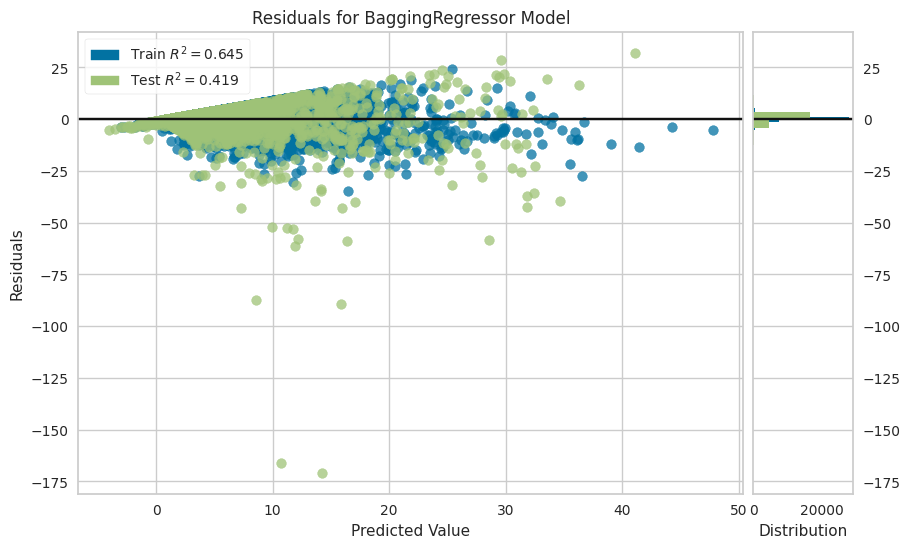

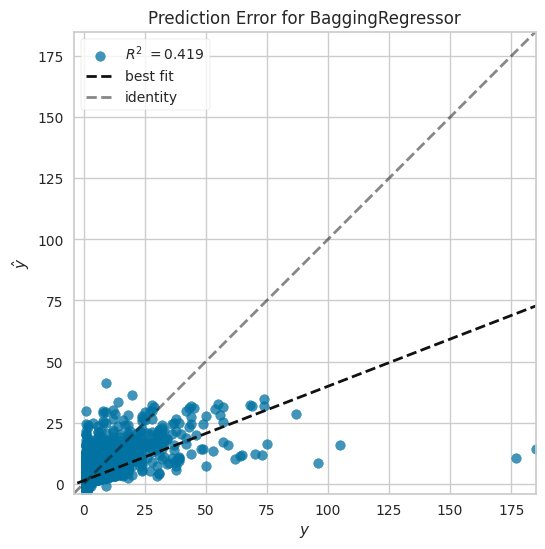

In [15]:
from pycaret.regression import tune_model, plot_model, evaluate_model
import matplotlib.pyplot as plt

# Gráfico de errores residuales
plt.figure(figsize=(10, 6))
plot_model(final_model_0, plot='residuals', save=False)

# Gráfico de predicción
plt.figure(figsize=(10, 6))
plot_model(final_model_0, plot='error')


##### **2.1.3 <ins>Predicción Ventas</ins>**

In [16]:
# Normalización de los datos numéricos
scaler = StandardScaler()

# Función para normalizar las columnas específicas en el DataFrame
def normalizar_columnas(df, columnas):
    df[columnas] = scaler.fit_transform(df[columnas])
    return df

# Aplicar la normalización a las columnas numéricas del DataFrame original
df_merged = normalizar_columnas(df_merged, ['Cant_vendidas', 'Precio_unidad', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7'])

# Obtenemos los productos únicos en el Cluster 0
productos = cluster_0['ID_producto'].unique()

# Solicitamos al usuario fecha de inicio de las predicciones y si hay promoción
fecha_inicio = input("Introduce la fecha de inicio para las predicciones (YYYY-MM-DD): ")
promocion_input = input("¿Alguno de los productos estará en promoción? (Si/No): ")

# Convertimos la fecha de inicio a un objeto datetime
fecha_inicio = datetime.strptime(fecha_inicio, "%Y-%m-%d")

# Verificamos que la fecha de inicio esté dentro del rango de los datos del Cluster 0
fecha_fin_datos_cluster_0 = cluster_0['Fecha_venta'].max()

if fecha_inicio <= fecha_fin_datos_cluster_0:
    print("La fecha de inicio debe ser posterior a la fecha final de los datos: ", fecha_fin_datos_cluster_0)
    exit(1)

# Inicializamos un diccionario para almacenar la información de promociones
promociones = {}
fecha_inicio_promo = None
fecha_fin_promo = None

if promocion_input.lower() == 'si':
    promo_tipo = input("¿Estarán en promoción 'Todos' o 'Algunos' los productos?: ").lower()
    fecha_inicio_promo = input("Introduce la fecha de inicio de la promoción (YYYY-MM-DD): ")
    fecha_fin_promo = input("Introduce la fecha de fin de la promoción (YYYY-MM-DD): ")
    fecha_inicio_promo = datetime.strptime(fecha_inicio_promo, "%Y-%m-%d")
    fecha_fin_promo = datetime.strptime(fecha_fin_promo, "%Y-%m-%d")

    if fecha_inicio_promo > fecha_fin_promo:
        raise ValueError("La fecha de inicio de la promoción debe ser anterior a la fecha de fin.")

    if promo_tipo == 'todos':
        promociones = {producto: 1 for producto in productos}
    elif promo_tipo == 'algunos':
        productos_en_promo = input("Enumere los IDs de los productos en promoción separados por comas: ").split(',')
        promociones = {producto: 1 if producto in productos_en_promo else 0 for producto in productos}
else:
    promociones = {producto: 0 for producto in productos}

# Función para obtener el precio del producto con manejo de errores
def obtener_precio(x, producto):
    try:
        if promocion_input.lower() == 'si' and fecha_inicio_promo <= x <= fecha_fin_promo:
            return df_merged_last_prices[(df_merged_last_prices['ID_producto'] == producto) &
                                         (df_merged_last_prices['Fecha_venta'] == x)]['Precio_unidad'].values[0]
        else:
            return df_merged_last_prices[df_merged_last_prices['ID_producto'] == producto]['Precio_unidad'].values[0]
    except IndexError:
        # Valor predeterminado si no se encuentra el precio
        return df_merged_last_prices[df_merged_last_prices['ID_producto'] == producto]['Precio_unidad'].mean()

# Función para predecir para un producto
def predecir_producto(producto):
    dias_a_predecir = 15
    fechas_prediccion = pd.date_range(start=fecha_inicio, periods=dias_a_predecir, freq='D')
    df_prediccion = pd.DataFrame(fechas_prediccion, columns=['Fecha_venta'])
    df_prediccion['ID_producto'] = producto
    df_prediccion['Precio_unidad'] = df_prediccion['Fecha_venta'].apply(lambda x: obtener_precio(x, producto))

    df_prediccion['Dia_sem'] = df_prediccion['Fecha_venta'].dt.strftime('%A').map({
        'Monday': 'Lunes',
        'Tuesday': 'Martes',
        'Wednesday': 'Miércoles',
        'Thursday': 'Jueves',
        'Friday': 'Viernes',
        'Saturday': 'Sábado',
        'Sunday': 'Domingo'
    }).astype('category')

    if promociones[producto] == 1:
        df_prediccion['Promocion'] = df_prediccion['Fecha_venta'].apply(lambda x: 'Si' if fecha_inicio_promo <= x <= fecha_fin_promo else 'No')
        if (fechas_prediccion.min() > fecha_fin_promo) or (fechas_prediccion.max() < fecha_inicio_promo):
            print(f"Alerta: La promoción para el producto {producto} está fuera del rango de predicción.")
    else:
        df_prediccion['Promocion'] = 'No'

    df_prediccion['Año'] = df_prediccion['Fecha_venta'].dt.year.astype('category')
    df_prediccion['Mes'] = df_prediccion['Fecha_venta'].dt.month.astype('category')
    df_prediccion['Dia_del_Mes'] = df_prediccion['Fecha_venta'].dt.day.astype('category')

    fecha_prev_lag = cluster_0[cluster_0['Fecha_venta'] == (fecha_inicio - timedelta(days=7))]['Lag_1'].mean()
    df_prediccion['Lag_1'] = fecha_prev_lag

    rolling_mean_7 = cluster_0[cluster_0['Fecha_venta'].between(fecha_inicio - timedelta(days=6), fecha_inicio)]['Rolling_Mean_7'].median()
    df_prediccion['Rolling_Mean_7'] = rolling_mean_7

    rolling_std_7 = cluster_0[cluster_0['Fecha_venta'].between(fecha_inicio - timedelta(days=6), fecha_inicio)]['Rolling_Std_7'].median()
    df_prediccion['Rolling_Std_7'] = rolling_std_7

    expected_columns = ['ID_producto', 'Precio_unidad', 'Dia_sem', 'Promocion', 'Año', 'Mes', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7', 'Dia_del_Mes']
    for col in expected_columns:
        if col not in df_prediccion.columns:
            raise ValueError(f"Missing column: {col}")

    predicciones = predict_model(final_model_0, data=df_prediccion)
    predicciones['ID_producto'] = producto
    predicciones['Precio_unidad'] = df_prediccion['Precio_unidad']
    predicciones['Promocion'] = df_prediccion['Promocion']
    predicciones['Dia_sem'] = df_prediccion['Dia_sem']

    predicciones['prediction_label'] = predicciones['prediction_label'].apply(lambda x: max(int(x) + 1 if x % 1 >= 0.5 else int(x), 0))

    media_predicciones = predicciones['prediction_label'].mean()
    predicciones['prediction_label'] = predicciones['prediction_label'].apply(lambda x: x if x > media_predicciones else 0)

    return predicciones

# Paralelizar la predicción para todos los productos
if __name__ == "__main__":
    with Pool(cpu_count()) as pool:
        all_predictions = pool.map(predecir_producto, productos)

    # Combinar todas las predicciones en un solo DataFrame
    all_predictions_df = pd.concat(all_predictions, ignore_index=True)

    df_final_predicciones_cluster_0 = all_predictions_df[['Fecha_venta', 'ID_producto', 'Dia_sem', 'Precio_unidad', 'Promocion', 'prediction_label']]
    df_final_predicciones_cluster_0.columns = ['Fecha_venta', 'ID_producto', 'Dia_sem', 'Precio_unidad', 'Promocion', 'Cantidades predichas']

    df_final_predicciones_cluster_0.reset_index(drop=True, inplace=True)

    df_resumen_cluster_0 = df_final_predicciones_cluster_0.groupby('ID_producto').agg(
        Fecha_inicio=('Fecha_venta', 'min'),
        Fecha_fin=('Fecha_venta', 'max'),
        Cantidades_vendidas=('Cantidades predichas', 'sum'),
        Facturacion=('Precio_unidad', lambda x: (x * df_final_predicciones_cluster_0.loc[x.index, 'Cantidades predichas']).sum())
    ).reset_index()

    df_final_predicciones_cluster_0.to_csv('predicciones_cluster_0.csv', index=False)
    df_resumen_cluster_0.to_csv('resumen_predicciones_cluster_0.csv', index=False)

Introduce la fecha de inicio para las predicciones (YYYY-MM-DD):  2024-05-02
¿Alguno de los productos estará en promoción? (Si/No):  nO}




##### **2.1.4 Visualización de <ins>predicciones</ins>**

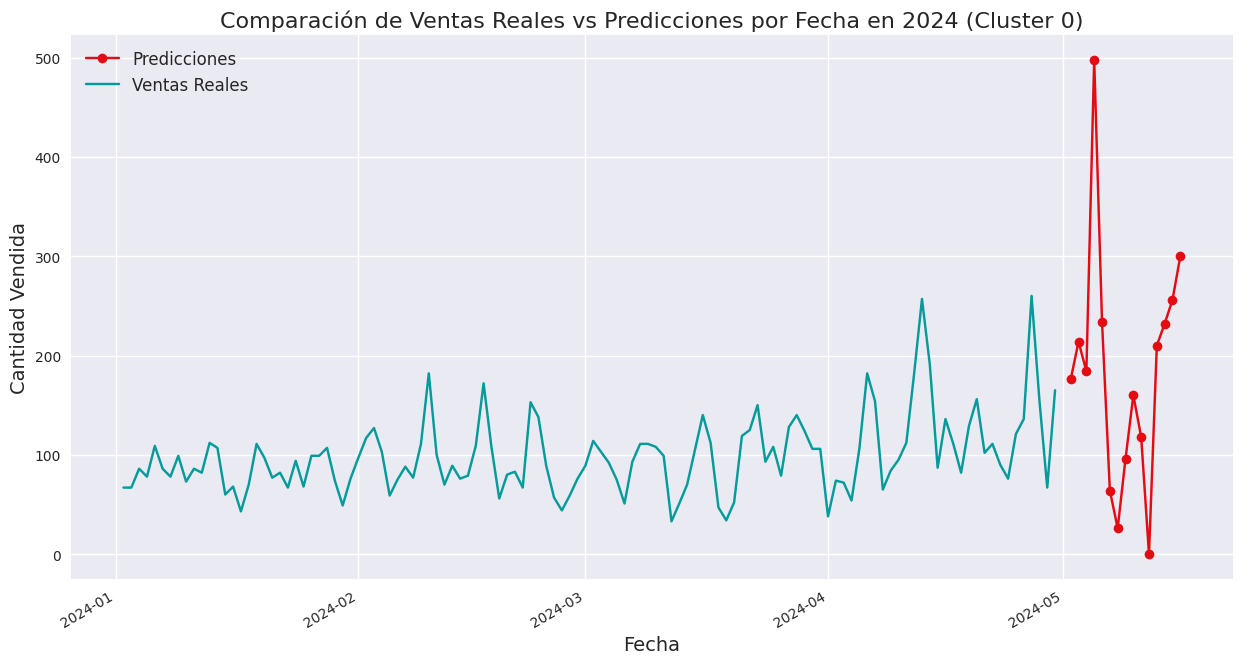

In [17]:
# Convertir la columna 'Fecha_venta' de df_merged a datetime si no lo está ya
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])
df_final_predicciones_cluster_0['Fecha_venta'] = pd.to_datetime(df_final_predicciones_cluster_0['Fecha_venta'])

# Filtrar los datos del año 2024 para el cluster 0
year_vigente = 2024
cluster_0_vigente = cluster_0[cluster_0['Fecha_venta'].dt.year == year_vigente]
predicciones_vigente_cluster_0 = df_final_predicciones_cluster_0[df_final_predicciones_cluster_0['Fecha_venta'].dt.year == year_vigente]

# Agrupar por fecha y sumar las cantidades vendidas y predichas
historicos_agrupados_cluster_0 = cluster_0_vigente.groupby('Fecha_venta')['Cant_vendidas'].sum().reset_index()
predicciones_agrupadas_cluster_0 = predicciones_vigente_cluster_0.groupby('Fecha_venta')['Cantidades predichas'].sum().reset_index()

plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predicciones_agrupadas_cluster_0['Fecha_venta'], predicciones_agrupadas_cluster_0['Cantidades predichas'], label='Predicciones', marker='o', linestyle='-', color='#e40b13')

# Gráfico de ventas reales
plt.plot(historicos_agrupados_cluster_0['Fecha_venta'], historicos_agrupados_cluster_0['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='#049b9b')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Intervalo mensual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato año-mes

plt.title('Comparación de Ventas Reales vs Predicciones por Fecha en 2024 (Cluster 0)', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('high_quality_chart_cluster_0.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()


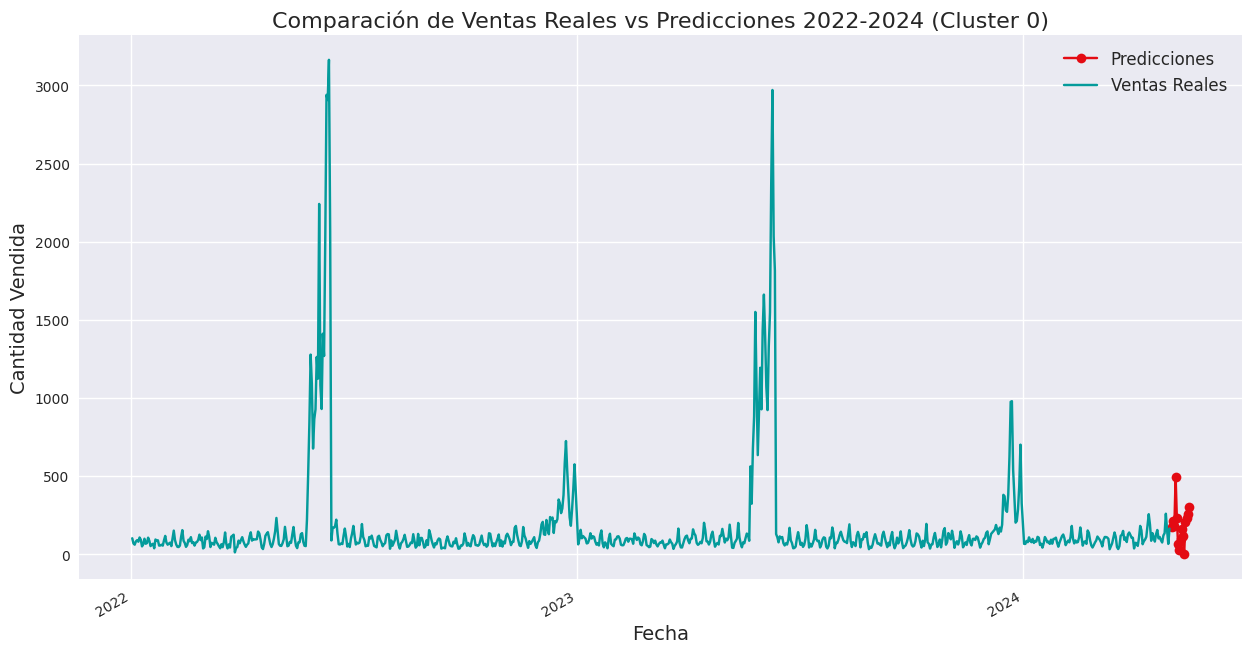

In [18]:
# Filtrar los datos desde el año 2022 hasta el 2024 para el cluster 0
start_year = 2022
end_year = 2024
mask = (cluster_0['Fecha_venta'].dt.year >= start_year) & (cluster_0['Fecha_venta'].dt.year <= end_year)
cluster_0_period = cluster_0[mask]
mask_pred = (df_final_predicciones_cluster_0['Fecha_venta'].dt.year >= start_year) & (df_final_predicciones_cluster_0['Fecha_venta'].dt.year <= end_year)
predicciones_period = df_final_predicciones_cluster_0[mask_pred]

# Agrupar por fecha y sumar las cantidades vendidas y predichas
historicos_agrupados = cluster_0_period.groupby('Fecha_venta')['Cant_vendidas'].sum().reset_index()
predicciones_agrupadas = predicciones_period.groupby('Fecha_venta')['Cantidades predichas'].sum().reset_index()

plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predicciones_agrupadas['Fecha_venta'], predicciones_agrupadas['Cantidades predichas'], label='Predicciones', marker='o', linestyle='-', color='#e40b13')

# Gráfico de ventas reales
plt.plot(historicos_agrupados['Fecha_venta'], historicos_agrupados['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='#049b9b')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Intervalo anual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato año

plt.title('Comparación de Ventas Reales vs Predicciones 2022-2024 (Cluster 0)', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('ventas_3_years.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()

##### **2.1.5  Resumen <ins>predicciones</ins>**

In [19]:
# Calcular el total de cantidades vendidas y el promedio de ventas por día
total_cantidades_vendidas = df_final_predicciones_cluster_0['Cantidades predichas'].sum()
promedio_ventas_por_dia = df_final_predicciones_cluster_0.groupby('Fecha_venta')['Cantidades predichas'].sum().mean()

# Calcular el total de facturación y el promedio de facturación por día
df_final_predicciones_cluster_0['Facturacion'] = df_final_predicciones_cluster_0['Cantidades predichas'] * df_final_predicciones_cluster_0['Precio_unidad']
total_facturacion = df_final_predicciones_cluster_0['Facturacion'].sum()
promedio_facturacion_por_dia = df_final_predicciones_cluster_0.groupby('Fecha_venta')['Facturacion'].sum().mean()

# Obtener el TOP 5 productos más vendidos con sus cantidades y el porcentaje sobre el total
top_5_productos = df_final_predicciones_cluster_0.groupby('ID_producto')['Cantidades predichas'].sum().nlargest(5)
top_5_productos = top_5_productos.reset_index()
top_5_productos['Porcentaje'] = round((top_5_productos['Cantidades predichas'] / total_cantidades_vendidas) * 100,2)

# Imprimir el resumen
print("Resumen de Ventas y Facturación para Cluster 0")
print("===========================================")
print(f"Total de Cantidades Vendidas: {total_cantidades_vendidas}")
print(f"Promedio de Ventas por Día: {promedio_ventas_por_dia:.2f}")
print(f"Total de Facturación: ${total_facturacion:.2f}")
print(f"Promedio de Facturación por Día: ${promedio_facturacion_por_dia:.2f}")
print("\nTOP 5 Productos Más Vendidos:")
print(top_5_productos)

Resumen de Ventas y Facturación para Cluster 0
Total de Cantidades Vendidas: 2768
Promedio de Ventas por Día: 184.53
Total de Facturación: $1884186.00
Promedio de Facturación por Día: $125612.40

TOP 5 Productos Más Vendidos:
   ID_producto  Cantidades predichas  Porcentaje
0       560473                    28        1.01
1       560627                    28        1.01
2       560867                    28        1.01
3       562386                    28        1.01
4       562556                    28        1.01




### **2.2 <ins>Cluster 1</ins>**



##### **2.2.1 Configuración de <ins>PyCaret</ins>**

In [20]:
## CONFIGURACIÓN DE PYCARET
# Configurar PyCaret para el Cluster 1
exp = setup(
    data=cluster_1,
    target='Cant_vendidas',
    categorical_features=['ID_producto', 'Dia_sem', 'Promocion', 'Año', 'Mes', 'Dia_del_Mes'],
    numeric_features=['Precio_unidad', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7'],
    ignore_features=['ID_tienda', 'Fecha_venta', 'Status', 'ID_proveedor', 'Clasif_proveedor', 'Categoria', 'Cluster', 'Facturacion'],
    normalize=True,
    transformation=True,
    #transformation_method='yeo-johnson',
    fold_strategy='timeseries',
    fold=5,
    session_id=123,
    data_split_shuffle=False,
    remove_outliers=False
)

,Description,Value
0,Session id,123
1,Target,Cant_vendidas
2,Target type,Regression
3,Original data shape,"(4851, 19)"
4,Transformed data shape,"(4851, 38)"
5,Transformed train set shape,"(3395, 38)"
6,Transformed test set shape,"(1456, 38)"
7,Ignore features,8
8,Numeric features,4
9,Categorical features,6



##### **2.2.2 Determinación <ins>modelo óptimo</ins>**

In [21]:
## DETERMINACIÓN MEJOR MODELO

from pycaret.regression import compare_models, tune_model

# Comparamos modelos y seleccionamos el mejor
best_model_1 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
rf,Random Forest Regressor,6.7482,443.0363,16.0604,0.6361,0.6422,1.8319,0.1320
xgboost,Extreme Gradient Boosting,6.6812,426.9204,16.0497,0.6048,0.6613,1.6342,0.0780
et,Extra Trees Regressor,7.6679,573.0022,18.3812,0.5667,0.6846,1.6780,0.1160
gbr,Gradient Boosting Regressor,7.7444,597.7269,18.6628,0.5589,0.6861,1.8442,0.1300
lightgbm,Light Gradient Boosting Machine,7.6258,571.9110,18.2606,0.5145,0.6990,1.9557,0.2240
catboost,CatBoost Regressor,7.2203,476.1898,17.2119,0.4779,0.6948,1.6658,1.2660
ada,AdaBoost Regressor,9.7952,514.6467,18.1129,0.2861,1.0683,3.6237,0.0800
knn,K Neighbors Regressor,9.5509,703.7609,22.1826,0.2545,0.8640,1.9635,0.0600
dt,Decision Tree Regressor,9.4878,918.9681,23.9713,0.2105,0.8445,1.9515,0.0600
huber,Huber Regressor,11.6262,860.5562,24.6577,-0.4858,1.0025,3.2623,0.0580


In [22]:
## AJUSTE DE MODELO

# Suponiendo que ya tienes tu mejor modelo optimizado
tuned_model_1 = tune_model(best_model_1, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,15.0141,1713.7590,41.3976,0.5267,1.0926,5.8215
1,1.8735,8.9923,2.9987,0.3657,0.4518,0.7115
2,9.8350,403.3517,20.0836,0.7489,0.6935,1.1959
3,2.4631,18.8360,4.3400,0.6090,0.5139,0.8409
4,5.4056,177.9220,13.3387,0.8036,0.4852,0.7206
Mean,6.9183,464.5722,16.4317,0.6108,0.6474,1.8581
Std,4.9323,640.7211,13.9488,0.1571,0.2378,1.9895


Fitting 5 folds for each of 10 candidates, totalling 50 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [23]:
from pycaret.regression import create_model, predict_model, ensemble_model, blend_models
#Ensamblaje tipo Boosting
boosted_model_1 = ensemble_model(tuned_model_1, method='Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14.6944,1796.9991,42.3910,0.5037,1.0857,5.4214
1,1.7577,7.2960,2.7011,0.4854,0.4464,0.7055
2,9.9232,417.6379,20.4362,0.7400,0.6726,1.1023
3,2.4560,20.6239,4.5414,0.5719,0.5155,0.8642
4,5.3404,180.3000,13.4276,0.8010,0.4748,0.7159
Mean,6.8343,484.5714,16.6995,0.6204,0.6390,1.7619
Std,4.8682,672.6911,14.3422,0.1274,0.2366,1.8354


In [24]:
# Ensamble usando bagging
bagged_dt_1 = ensemble_model(tuned_model_1, method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14.7906,1654.7702,40.6789,0.5430,1.1056,6.0077
1,1.7334,7.0867,2.6621,0.5001,0.4409,0.6942
2,9.7097,387.9551,19.6966,0.7585,0.6965,1.3030
3,2.3820,19.0660,4.3665,0.6042,0.5055,0.8293
4,5.2159,162.2222,12.7366,0.8209,0.4669,0.6722
Mean,6.7663,446.2201,16.0281,0.6454,0.6431,1.9013
Std,4.8992,619.6679,13.7593,0.1240,0.2480,2.0658


In [25]:
catboost = create_model('catboost')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.7761,1576.5270,39.7055,0.5646,1.0554,4.1531
1,2.7151,16.6628,4.0820,-0.1753,0.6679,1.3900
2,11.4077,583.3283,24.1522,0.6369,0.7422,1.2480
3,2.5679,20.9131,4.5731,0.5659,0.5483,0.9040
4,5.6346,183.5178,13.5469,0.7974,0.4601,0.6336
Mean,7.2203,476.1898,17.2119,0.4779,0.6948,1.6658
Std,4.5819,587.5916,13.4141,0.3374,0.2047,1.2714


In [26]:
# Crear un modelo de ensamble
ensemble_model_1 = blend_models([tuned_model_1, catboost])


,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,13.9687,1500.6439,38.7381,0.5856,1.0749,4.9495
1,2.1571,9.3972,3.0655,0.3372,0.5522,1.0251
2,10.2583,447.7605,21.1604,0.7213,0.6893,1.1754
3,2.4101,19.5493,4.4215,0.5942,0.5120,0.8396
4,5.1639,166.7773,12.9142,0.8159,0.4521,0.6336
Mean,6.7916,428.8256,16.0599,0.6108,0.6561,1.7247
Std,4.6229,558.7933,13.0730,0.1613,0.2235,1.6226


In [27]:
final_model_1 = create_model(boosted_model_1)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,14.6944,1796.9991,42.3910,0.5037,1.0857,5.4214
1,1.7577,7.2960,2.7011,0.4854,0.4464,0.7055
2,9.9232,417.6379,20.4362,0.7400,0.6726,1.1023
3,2.4560,20.6239,4.5414,0.5719,0.5155,0.8642
4,5.3404,180.3000,13.4276,0.8010,0.4748,0.7159
Mean,6.8343,484.5714,16.6995,0.6204,0.6390,1.7619
Std,4.8682,672.6911,14.3422,0.1274,0.2366,1.8354


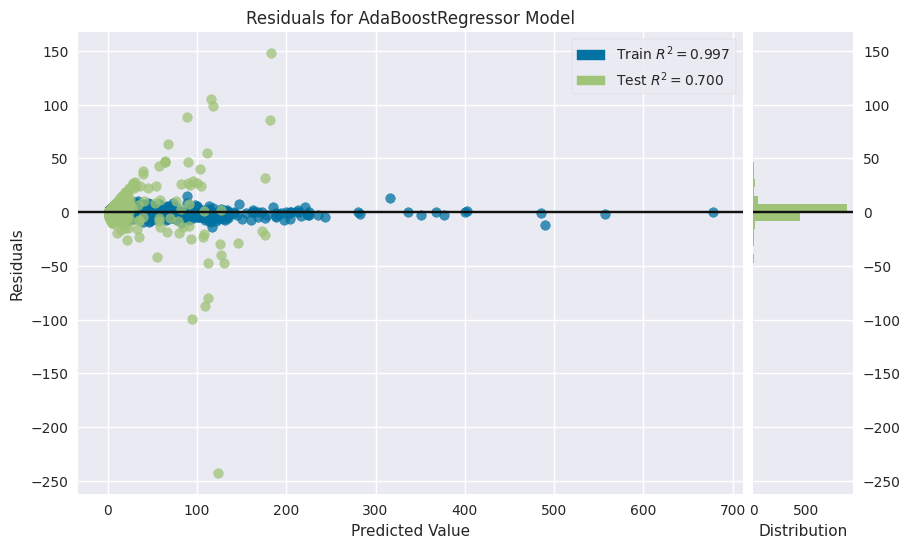

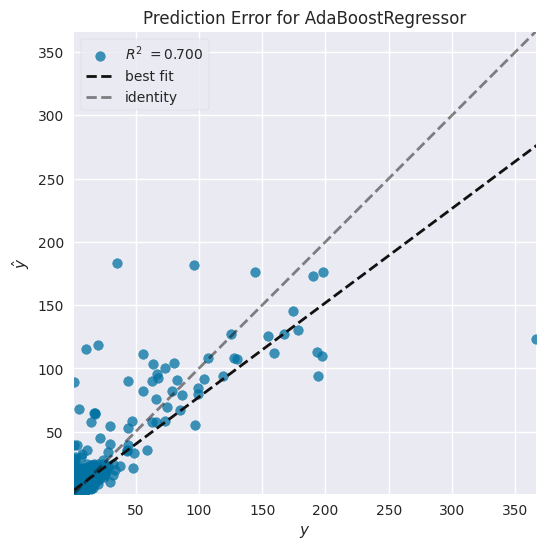

In [28]:
# Gráfico de errores residuales
plt.figure(figsize=(10, 6))
plot_model(final_model_1, plot='residuals', save=False)

# Gráfico de predicción
plt.figure(figsize=(10, 6))
plot_model(final_model_1, plot='error')


##### **2.2.3 <ins>Predicción Ventas</ins>**

In [29]:
# Normalización de los datos numéricos para Cluster 1
scaler_cluster_1 = StandardScaler()

# Función para normalizar las columnas específicas en el DataFrame para Cluster 1
def normalizar_columnas_cluster_1(df, columnas):
    df[columnas] = scaler_cluster_1.fit_transform(df[columnas])
    return df

# Aplicar la normalización a las columnas numéricas del DataFrame original específicamente para Cluster 1
df_merged_cluster_1 = normalizar_columnas_cluster_1(df_merged, ['Cant_vendidas', 'Precio_unidad', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7'])

# Obtenemos los productos únicos en el Cluster 1
productos_cluster_1 = cluster_1['ID_producto'].unique()

# Solicitamos al usuario fecha de inicio de las predicciones y si hay promoción para Cluster 1
fecha_inicio_cluster_1 = input("Introduce la fecha de inicio para las predicciones del Cluster 1 (YYYY-MM-DD): ")
promocion_input_cluster_1 = input("¿Alguno de los productos del Cluster 1 estará en promoción? (Si/No): ")

# Convertimos la fecha de inicio a un objeto datetime para Cluster 1
fecha_inicio_cluster_1 = datetime.strptime(fecha_inicio_cluster_1, "%Y-%m-%d")

# Verificamos que la fecha de inicio esté dentro del rango de los datos del Cluster 1
fecha_fin_datos_cluster_1 = cluster_1['Fecha_venta'].max()

if fecha_inicio_cluster_1 <= fecha_fin_datos_cluster_1:
    print("La fecha de inicio debe ser posterior a la fecha final de los datos: ", fecha_fin_datos_cluster_1)
    exit(1)

# Inicializamos un diccionario para almacenar la información de promociones para Cluster 1
promociones_cluster_1 = {}
fecha_inicio_promo_cluster_1 = None
fecha_fin_promo_cluster_1 = None

if promocion_input_cluster_1.lower() == 'si':
    promo_tipo_cluster_1 = input("¿Estarán en promoción 'Todos' o 'Algunos' los productos del Cluster 1?: ").lower()
    fecha_inicio_promo_cluster_1 = input("Introduce la fecha de inicio de la promoción del Cluster 1 (YYYY-MM-DD): ")
    fecha_fin_promo_cluster_1 = input("Introduce la fecha de fin de la promoción del Cluster 1 (YYYY-MM-DD): ")
    fecha_inicio_promo_cluster_1 = datetime.strptime(fecha_inicio_promo_cluster_1, "%Y-%m-%d")
    fecha_fin_promo_cluster_1 = datetime.strptime(fecha_fin_promo_cluster_1, "%Y-%m-%d")

    if fecha_inicio_promo_cluster_1 > fecha_fin_promo_cluster_1:
        raise ValueError("La fecha de inicio de la promoción debe ser anterior a la fecha de fin.")

    if promo_tipo_cluster_1 == 'todos':
        promociones_cluster_1 = {producto: 1 for producto in productos_cluster_1}
    elif promo_tipo_cluster_1 == 'algunos':
        productos_en_promo_cluster_1 = input("Enumere los IDs de los productos en promoción del Cluster 1 separados por comas: ").split(',')
        promociones_cluster_1 = {producto: 1 if producto in productos_en_promo_cluster_1 else 0 for producto in productos_cluster_1}
else:
    promociones_cluster_1 = {producto: 0 for producto in productos_cluster_1}

# Función para obtener el precio del producto con manejo de errores para Cluster 1
def obtener_precio_cluster_1(x, producto):
    try:
        if promocion_input_cluster_1.lower() == 'si' and fecha_inicio_promo_cluster_1 <= x <= fecha_fin_promo_cluster_1:
            return df_merged_last_prices[(df_merged_last_prices['ID_producto'] == producto) &
                                         (df_merged_last_prices['Fecha_venta'] == x)]['Precio_unidad'].values[0]
        else:
            return df_merged_last_prices[df_merged_last_prices['ID_producto'] == producto]['Precio_unidad'].values[0]
    except IndexError:
        # Valor predeterminado si no se encuentra el precio
        return df_merged_last_prices[df_merged_last_prices['ID_producto'] == producto]['Precio_unidad'].mean()

# Función para predecir para un producto en Cluster 1
def predecir_producto_cluster_1(producto):
    dias_a_predecir = 15
    fechas_prediccion_cluster_1 = pd.date_range(start=fecha_inicio_cluster_1, periods=dias_a_predecir, freq='D')
    df_prediccion_cluster_1 = pd.DataFrame(fechas_prediccion_cluster_1, columns=['Fecha_venta'])
    df_prediccion_cluster_1['ID_producto'] = producto
    df_prediccion_cluster_1['Precio_unidad'] = df_prediccion_cluster_1['Fecha_venta'].apply(lambda x: obtener_precio_cluster_1(x, producto))

    df_prediccion_cluster_1['Dia_sem'] = df_prediccion_cluster_1['Fecha_venta'].dt.strftime('%A').map({
        'Monday': 'Lunes',
        'Tuesday': 'Martes',
        'Wednesday': 'Miércoles',
        'Thursday': 'Jueves',
        'Friday': 'Viernes',
        'Saturday': 'Sábado',
        'Sunday': 'Domingo'
    }).astype('category')

    if promociones_cluster_1[producto] == 1:
        df_prediccion_cluster_1['Promocion'] = df_prediccion_cluster_1['Fecha_venta'].apply(lambda x: 'Si' if fecha_inicio_promo_cluster_1 <= x <= fecha_fin_promo_cluster_1 else 'No')
        if (fechas_prediccion_cluster_1.min() > fecha_fin_promo_cluster_1) or (fechas_prediccion_cluster_1.max() < fecha_inicio_promo_cluster_1):
            print(f"Alerta: La promoción para el producto {producto} está fuera del rango de predicción.")
    else:
        df_prediccion_cluster_1['Promocion'] = 'No'

    df_prediccion_cluster_1['Año'] = df_prediccion_cluster_1['Fecha_venta'].dt.year.astype('category')
    df_prediccion_cluster_1['Mes'] = df_prediccion_cluster_1['Fecha_venta'].dt.month.astype('category')
    df_prediccion_cluster_1['Dia_del_Mes'] = df_prediccion_cluster_1['Fecha_venta'].dt.day.astype('category')

    fecha_prev_lag = cluster_1[cluster_1['Fecha_venta'] == (fecha_inicio_cluster_1 - timedelta(days=7))]['Lag_1'].mean()
    df_prediccion_cluster_1['Lag_1'] = fecha_prev_lag

    rolling_mean_7 = cluster_1[cluster_1['Fecha_venta'].between(fecha_inicio_cluster_1 - timedelta(days=6), fecha_inicio_cluster_1)]['Rolling_Mean_7'].median()
    df_prediccion_cluster_1['Rolling_Mean_7'] = rolling_mean_7

    rolling_std_7 = cluster_1[cluster_1['Fecha_venta'].between(fecha_inicio_cluster_1 - timedelta(days=6), fecha_inicio_cluster_1)]['Rolling_Std_7'].median()
    df_prediccion_cluster_1['Rolling_Std_7'] = rolling_std_7

    expected_columns = ['ID_producto', 'Precio_unidad', 'Dia_sem', 'Promocion', 'Año', 'Mes', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7', 'Dia_del_Mes']
    for col in expected_columns:
        if col not in df_prediccion_cluster_1.columns:
            raise ValueError(f"Missing column: {col}")

    predicciones_cluster_1 = predict_model(final_model_1, data=df_prediccion_cluster_1)
    predicciones_cluster_1['ID_producto'] = producto
    predicciones_cluster_1['Precio_unidad'] = df_prediccion_cluster_1['Precio_unidad']
    predicciones_cluster_1['Promocion'] = df_prediccion_cluster_1['Promocion']
    predicciones_cluster_1['Dia_sem'] = df_prediccion_cluster_1['Dia_sem']

    predicciones_cluster_1['prediction_label'] = predicciones_cluster_1['prediction_label'].apply(lambda x: max(int(x) + 1 if x % 1 >= 0.5 else int(x), 0))

    return predicciones_cluster_1

# Paralelizar la predicción para todos los productos del Cluster 1
if __name__ == "__main__":
    with Pool(cpu_count()) as pool:
        all_predictions_cluster_1 = pool.map(predecir_producto_cluster_1, productos_cluster_1)

    # Combinar todas las predicciones en un solo DataFrame para Cluster 1
    all_predictions_df_cluster_1 = pd.concat(all_predictions_cluster_1, ignore_index=True)

    df_final_predicciones_cluster_1 = all_predictions_df_cluster_1[['Fecha_venta', 'ID_producto', 'Dia_sem', 'Precio_unidad', 'Promocion', 'prediction_label']]
    df_final_predicciones_cluster_1.columns = ['Fecha_venta', 'ID_producto', 'Dia_sem', 'Precio_unidad', 'Promocion', 'Cantidades predichas']

    df_final_predicciones_cluster_1.reset_index(drop=True, inplace=True)

    df_resumen_cluster_1 = df_final_predicciones_cluster_1.groupby('ID_producto').agg(
        Fecha_inicio=('Fecha_venta', 'min'),
        Fecha_fin=('Fecha_venta', 'max'),
        Cantidades_vendidas=('Cantidades predichas', 'sum'),
        Facturacion=('Precio_unidad', lambda x: (x * df_final_predicciones_cluster_1.loc[x.index, 'Cantidades predichas']).sum())
    ).reset_index()

    df_final_predicciones_cluster_1.to_csv('predicciones_cluster_1.csv', index=False)
    df_resumen_cluster_1.to_csv('resumen_predicciones_cluster_1.csv', index=False)

Introduce la fecha de inicio para las predicciones del Cluster 1 (YYYY-MM-DD):  2024-05-02
¿Alguno de los productos del Cluster 1 estará en promoción? (Si/No):  No



##### **2.2.4 Visualización de <ins>predicciones</ins>**

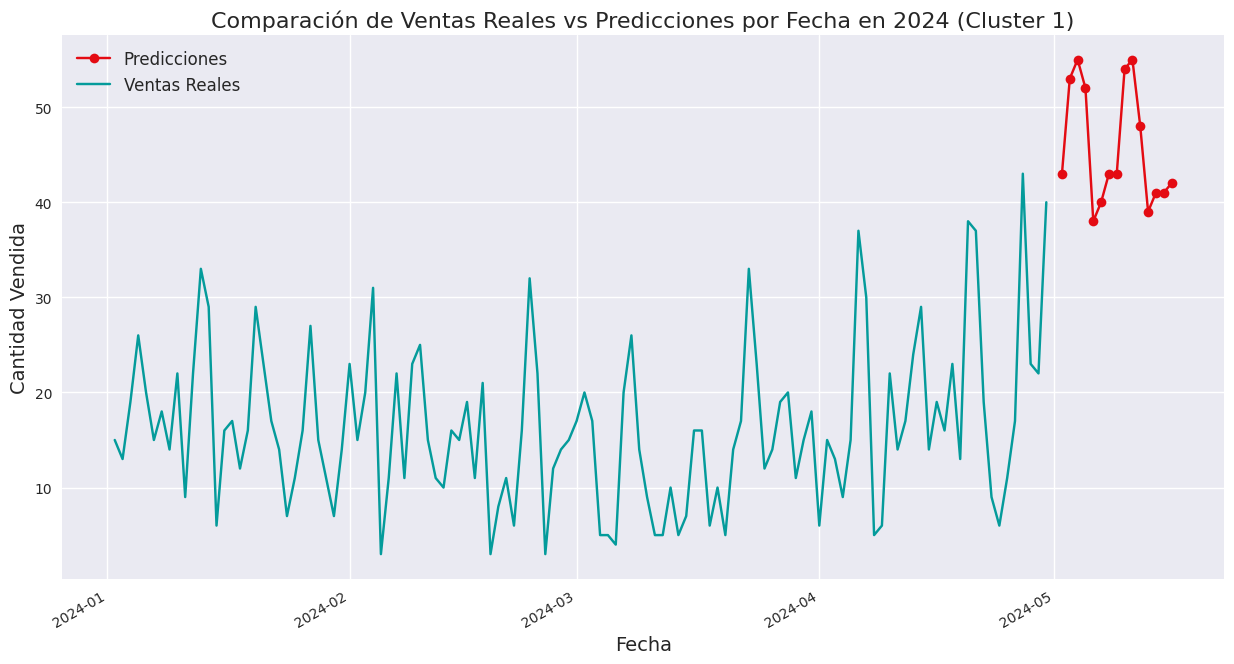

In [30]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime

# Convertir la columna 'Fecha_venta' de df_merged a datetime si no lo está ya
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])
df_final_predicciones_cluster_1['Fecha_venta'] = pd.to_datetime(df_final_predicciones_cluster_1['Fecha_venta'])

# Filtrar los datos del año 2024 para el cluster 1
year_vigente = 2024
cluster_1_vigente = cluster_1[cluster_1['Fecha_venta'].dt.year == year_vigente]
predicciones_vigente_cluster_1 = df_final_predicciones_cluster_1[df_final_predicciones_cluster_1['Fecha_venta'].dt.year == year_vigente]

# Agrupar por fecha y sumar las cantidades vendidas y predichas
historicos_agrupados_cluster_1 = cluster_1_vigente.groupby('Fecha_venta')['Cant_vendidas'].sum().reset_index()
predicciones_agrupadas_cluster_1 = predicciones_vigente_cluster_1.groupby('Fecha_venta')['Cantidades predichas'].sum().reset_index()

plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predicciones_agrupadas_cluster_1['Fecha_venta'], predicciones_agrupadas_cluster_1['Cantidades predichas'], label='Predicciones', marker='o', linestyle='-', color='#e40b13')

# Gráfico de ventas reales
plt.plot(historicos_agrupados_cluster_1['Fecha_venta'], historicos_agrupados_cluster_1['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='#049b9b')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Intervalo mensual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato año-mes

plt.title('Comparación de Ventas Reales vs Predicciones por Fecha en 2024 (Cluster 1)', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('high_quality_chart_cluster_1.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()

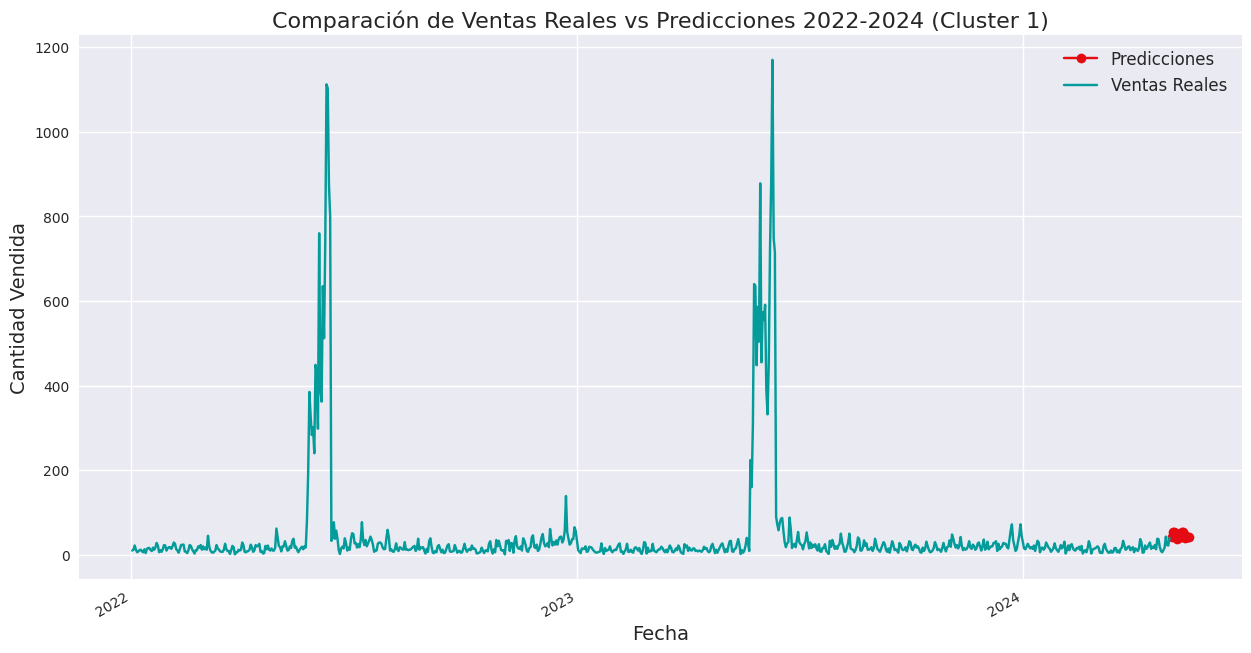

In [31]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pandas as pd
from datetime import datetime

# Filtrar los datos desde el año 2022 hasta el 2024 para el cluster 1
start_year = 2022
end_year = 2024
mask_cluster_1 = (cluster_1['Fecha_venta'].dt.year >= start_year) & (cluster_1['Fecha_venta'].dt.year <= end_year)
cluster_1_period = cluster_1[mask_cluster_1]
mask_pred_cluster_1 = (df_final_predicciones_cluster_1['Fecha_venta'].dt.year >= start_year) & (df_final_predicciones_cluster_1['Fecha_venta'].dt.year <= end_year)
predicciones_period_cluster_1 = df_final_predicciones_cluster_1[mask_pred_cluster_1]

# Agrupar por fecha y sumar las cantidades vendidas y predichas
historicos_agrupados_cluster_1 = cluster_1_period.groupby('Fecha_venta')['Cant_vendidas'].sum().reset_index()
predicciones_agrupadas_cluster_1 = predicciones_period_cluster_1.groupby('Fecha_venta')['Cantidades predichas'].sum().reset_index()

plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predicciones_agrupadas_cluster_1['Fecha_venta'], predicciones_agrupadas_cluster_1['Cantidades predichas'], label='Predicciones', marker='o', linestyle='-', color='#e40b13')

# Gráfico de ventas reales
plt.plot(historicos_agrupados_cluster_1['Fecha_venta'], historicos_agrupados_cluster_1['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='#049b9b')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Intervalo anual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato año

plt.title('Comparación de Ventas Reales vs Predicciones 2022-2024 (Cluster 1)', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('ventas_3_years_cluster_1.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()


##### **2.2.5  Resumen <ins>predicciones</ins>**

In [32]:
# Calcular el total de cantidades vendidas y el promedio de ventas por día
total_cantidades_vendidas = df_final_predicciones_cluster_1['Cantidades predichas'].sum()
promedio_ventas_por_dia = df_final_predicciones_cluster_1.groupby('Fecha_venta')['Cantidades predichas'].sum().mean()

# Calcular el total de facturación y el promedio de facturación por día
df_final_predicciones_cluster_1['Facturacion'] = df_final_predicciones_cluster_1['Cantidades predichas'] * df_final_predicciones_cluster_1['Precio_unidad']
total_facturacion = df_final_predicciones_cluster_1['Facturacion'].sum()
promedio_facturacion_por_dia = df_final_predicciones_cluster_1.groupby('Fecha_venta')['Facturacion'].sum().mean()

# Obtener el TOP 5 productos más vendidos con sus cantidades y el porcentaje sobre el total
top_5_productos = df_final_predicciones_cluster_1.groupby('ID_producto')['Cantidades predichas'].sum().nlargest(5)
top_5_productos = top_5_productos.reset_index()
top_5_productos['Porcentaje'] = round((top_5_productos['Cantidades predichas'] / total_cantidades_vendidas) * 100, 2)

# Imprimir el resumen
print("Resumen de Ventas y Facturación para Cluster 1")
print("===========================================")
print(f"Total de Cantidades Vendidas: {total_cantidades_vendidas}")
print(f"Promedio de Ventas por Día: {promedio_ventas_por_dia:.2f}")
print(f"Total de Facturación: ${total_facturacion:.2f}")
print(f"Promedio de Facturación por Día: ${promedio_facturacion_por_dia:.2f}")
print("\nTOP 5 Productos Más Vendidos:")
print(top_5_productos)

Resumen de Ventas y Facturación para Cluster 1
Total de Cantidades Vendidas: 687
Promedio de Ventas por Día: 45.80
Total de Facturación: $432224.00
Promedio de Facturación por Día: $28814.93

TOP 5 Productos Más Vendidos:
   ID_producto  Cantidades predichas  Porcentaje
0       561636                   113       16.45
1       560032                   104       15.14
2       561278                    87       12.66
3       561395                    81       11.79
4       560978                    66        9.61


### **2.3 <ins>Cluster 2</ins>**

El **<ins>cluster 2</ins> está <ins>compuesto unicamente por 3 productos</ins>**: **'562124', '560724' y '562809'** los cuales <ins>han registrado únicamente 2,5 1 ventas</ins> respectivamente. Según se ha consultado la base de ventas histórica, <ins>ninguna de estas ha acontecido durante el mes de mayo</ins> *(mes que se está buscando predecir)*, por lo cual puede concluirse que la probabilidad de ventas para estos tres productos en el período mencionado es 0.

No obstnante, y **como <ins>mecanismo de prevención</ins>, recomendamos  <ins>asumir una predicción de una sola venta para cada uno de estos productos</ins> durante la quincena**. Esto con el objetivo de que el el local se encuentre debidamente preparado ante una eventual suceso de estos.


In [219]:
# Definir productos del Cluster 2 y sus precios
productos_cluster_2 = ['562124', '560724', '562809']
precios_cluster_2 = {'562124': 10525, '560724': 19190, '562809': 35000}

# Usar la misma fecha de inicio especificada para el Cluster 1
fecha_inicio_cluster_2 = fecha_inicio_cluster_1
fecha_fin_cluster_2 = fecha_inicio_cluster_2 + timedelta(days=14)

# Crear DataFrame para predicciones (una sola venta por producto durante la quincena)
df_final_predicciones_cluster_2 = pd.DataFrame({
    'Fecha_venta': [fecha_inicio_cluster_2] * len(productos_cluster_2),
    'ID_producto': productos_cluster_2,
    'Dia_sem': pd.to_datetime([fecha_inicio_cluster_2] * len(productos_cluster_2)).strftime('%A').map({
        'Monday': 'Lunes',
        'Tuesday': 'Martes',
        'Wednesday': 'Miércoles',
        'Thursday': 'Jueves',
        'Friday': 'Viernes',
        'Saturday': 'Sábado',
        'Sunday': 'Domingo'
    }).astype('category'),
    'Cantidades predichas': [1] * len(productos_cluster_2),  # Una sola venta por producto
    'Precio_unidad': [precios_cluster_2[producto] for producto in productos_cluster_2],
    'Promocion': 'No'
})

# Crear DataFrame de resumen
df_resumen_cluster_2 = df_final_predicciones_cluster_2.groupby('ID_producto').agg(
    Fecha_inicio=('Fecha_venta', 'min'),
    Fecha_fin=('Fecha_venta', lambda x: fecha_fin_cluster_2),
    Cantidades_vendidas=('Cantidades predichas', 'sum'),
    Facturacion=('Precio_unidad', lambda x: (x * df_final_predicciones_cluster_2.loc[x.index, 'Cantidades predichas']).sum())
).reset_index()

# Guardar DataFrames en la memoria
df_final_predicciones_cluster_2_memory = df_final_predicciones_cluster_2
df_resumen_cluster_2_memory = df_resumen_cluster_2

# Guardar DataFrames como archivos CSV
df_final_predicciones_cluster_2.to_csv('predicciones_cluster_2.csv', index=False)
df_resumen_cluster_2.to_csv('resumen_predicciones_cluster_2.csv', index=False)

# Imprimir resultados
print("Resumen de Ventas y Facturación para Cluster 2")
print("===========================================")
print(f"Total de Cantidades Vendidas: {df_final_predicciones_cluster_2['Cantidades predichas'].sum()}")
print(f"Total de Facturación: ${df_resumen_cluster_2['Facturacion'].sum():.2f}")
print("\nDetalle de productos:")
print(df_resumen_cluster_2)

Resumen de Ventas y Facturación para Cluster 2
Total de Cantidades Vendidas: 3
Total de Facturación: $64715.00

Detalle de productos:
  ID_producto Fecha_inicio  Fecha_fin  Cantidades_vendidas  Facturacion
0      560724   2024-05-02 2024-05-16                    1        19190
1      562124   2024-05-02 2024-05-16                    1        10525
2      562809   2024-05-02 2024-05-16                    1        35000


### **2.4 <ins>Cluster 3</ins>**

##### **2.4.1 Configuración de <ins>PyCaret</ins>**

In [34]:
## CONFIGURACIÓN DE PYCARET
# Configurar PyCaret para el Cluster 3
exp = setup(
    data=cluster_3,
    target='Cant_vendidas',
    categorical_features=['ID_producto', 'Dia_sem', 'Promocion', 'Año', 'Mes', 'Dia_del_Mes'],
    numeric_features=['Precio_unidad', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7'],
    ignore_features=['ID_tienda', 'Fecha_venta', 'Status', 'ID_proveedor', 'Clasif_proveedor', 'Categoria', 'Cluster', 'Facturacion'],
    normalize=True,
    transformation=True,
    #transformation_method='yeo-johnson',
    fold_strategy='timeseries',
    fold=5,
    session_id=123,
    data_split_shuffle=False,
    remove_outliers=True)

,Description,Value
0,Session id,123
1,Target,Cant_vendidas
2,Target type,Regression
3,Original data shape,"(35612, 19)"
4,Transformed data shape,"(34365, 30)"
5,Transformed train set shape,"(23681, 30)"
6,Transformed test set shape,"(10684, 30)"
7,Ignore features,8
8,Numeric features,4
9,Categorical features,6


##### **2.4.2 Determinación <ins>modelo óptimo</ins>**

In [35]:
## DETERMINACIÓN MEJOR MODELO

# Comparamos modelos y seleccionamos el mejor
best_model_3 = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,4.1895,162.6860,10.8696,0.3827,0.6191,1.1940,0.3260
catboost,CatBoost Regressor,4.0083,154.5759,10.7993,0.3560,0.6075,1.0829,2.1960
lightgbm,Light Gradient Boosting Machine,3.9441,142.2845,10.5363,0.3301,0.5999,1.1710,0.2940
rf,Random Forest Regressor,3.9904,139.8113,10.5541,0.3138,0.6158,1.2809,0.3800
gbr,Gradient Boosting Regressor,4.1188,152.3748,10.9065,0.2720,0.6152,1.2775,0.5940
xgboost,Extreme Gradient Boosting,4.2843,168.4572,11.4410,0.1996,0.6424,1.2945,0.2440
knn,K Neighbors Regressor,4.5060,196.0854,12.1489,0.1793,0.6888,0.9400,0.2680
ada,AdaBoost Regressor,4.8302,147.2947,11.0501,0.1421,0.7753,2.0574,0.3280
en,Elastic Net,5.1463,191.4476,12.2666,0.1277,0.7820,1.6795,0.5480
lasso,Lasso Regression,5.1448,193.3380,12.3155,0.1203,0.7716,1.6189,0.5760


In [36]:
## AJUSTE DE MODELO

# Suponiendo que ya tienes tu mejor modelo optimizado
tuned_model_3 = tune_model(best_model_3, optimize='R2')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.3044,263.6525,16.2374,0.4194,0.8143,2.0487
1,1.4476,11.5938,3.4050,0.5263,0.4347,0.7620
2,8.1501,326.3282,18.0646,0.2208,0.7649,1.0302
3,2.1742,107.2980,10.3585,0.3118,0.4743,0.8032
4,1.8074,19.5241,4.4186,0.5355,0.4580,0.7748
Mean,3.9767,145.6793,10.4968,0.4028,0.5893,1.0838
Std,2.7271,127.9991,5.9579,0.1221,0.1648,0.4923


Fitting 5 folds for each of 10 candidates, totalling 50 fits


In [37]:
from pycaret.regression import create_model, predict_model, ensemble_model, blend_models
#Ensamblaje tipo Boosting
boosted_model_3 = ensemble_model(tuned_model_3, method='Boosting')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.6892,274.1729,16.5582,0.3962,0.8536,2.3528
1,1.5157,12.4436,3.5276,0.4916,0.4517,0.8190
2,8.4509,331.2426,18.2001,0.2091,0.8230,1.7262
3,2.2646,108.6365,10.4229,0.3032,0.4909,0.8669
4,1.7909,16.1472,4.0184,0.6158,0.4652,0.8185
Mean,4.1423,148.5286,10.5454,0.4032,0.6169,1.3167
Std,2.8637,131.7621,6.1093,0.1420,0.1815,0.6228


In [38]:
# Ensamble usando bagging
bagged_dt_3 = ensemble_model(tuned_model_3, method='Bagging')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.2464,273.3634,16.5337,0.3980,0.7939,1.8870
1,1.4445,11.1961,3.3461,0.5426,0.4350,0.7653
2,8.3682,350.0931,18.7108,0.1641,0.7830,0.9760
3,2.1818,108.1047,10.3973,0.3066,0.4730,0.7961
4,1.8008,19.0484,4.3644,0.5468,0.4581,0.7735
Mean,4.0083,152.3612,10.6705,0.3916,0.5886,1.0396
Std,2.7857,136.6733,6.2050,0.1455,0.1637,0.4307


In [39]:
lightgbm_3 = create_model('lightgbm')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7.3225,328.7689,18.1320,0.2760,0.8920,2.5945
1,1.6273,24.9441,4.9944,-0.0191,0.4593,0.8195
2,7.0937,231.6668,15.2206,0.4469,0.7647,1.0706
3,2.0855,111.9543,10.5808,0.2819,0.4577,0.7011
4,1.5913,14.0882,3.7534,0.6648,0.4259,0.6692
Mean,3.9441,142.2845,10.5363,0.3301,0.5999,1.1710
Std,2.6718,121.5636,5.5921,0.2249,0.1912,0.7256


In [40]:
# Crear un modelo de ensamble
ensemble_model_3 = blend_models([tuned_model_3, lightgbm_3])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,6.7501,289.0478,17.0014,0.3634,0.8519,2.3145
1,1.5239,15.0435,3.8786,0.3854,0.4455,0.7866
2,7.4593,266.8595,16.3358,0.3628,0.7312,1.0211
3,2.1129,109.1219,10.4461,0.3001,0.4604,0.7469
4,1.6779,15.9746,3.9968,0.6199,0.4376,0.7194
Mean,3.9048,139.2094,10.3318,0.4063,0.5853,1.1177
Std,2.6294,118.5372,5.6977,0.1105,0.1728,0.6079


In [41]:
final_model_3 = ensemble_model_3

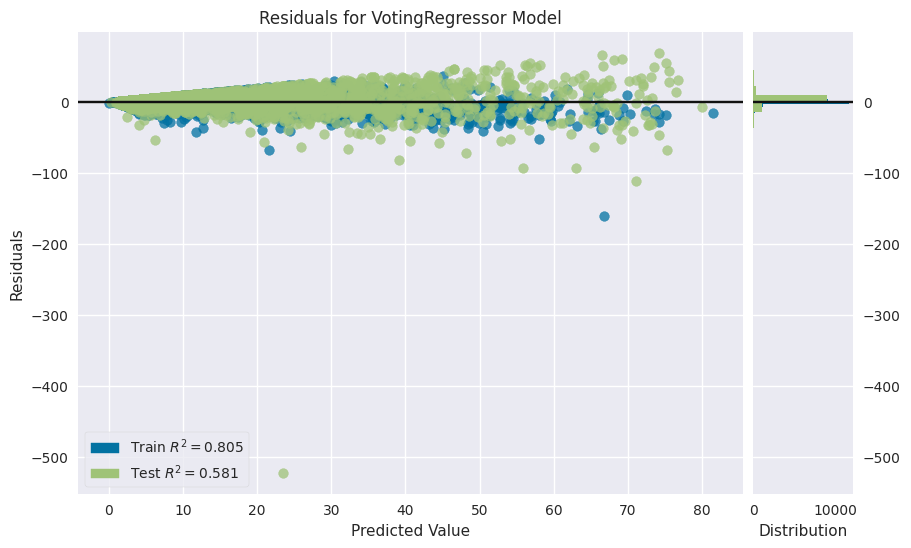

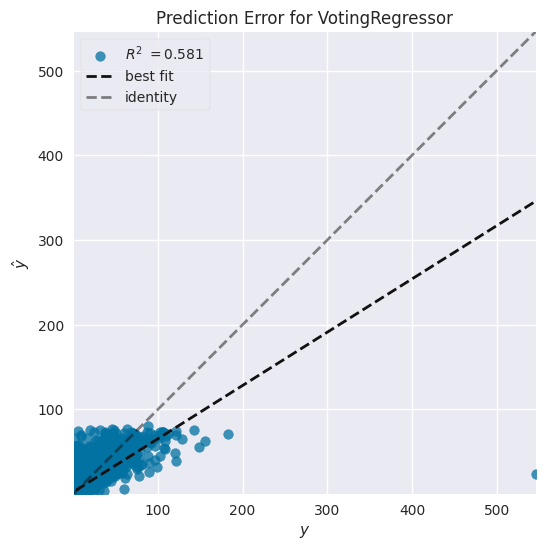

In [42]:
# Gráfico de errores residuales
plt.figure(figsize=(10, 6))
plot_model(final_model_3, plot='residuals', save=False)

# Gráfico de predicción
plt.figure(figsize=(10, 6))
plot_model(final_model_3, plot='error')

##### **2.4.3 <ins>Predicción Ventas</ins>**

In [43]:
import pandas as pd
from datetime import datetime, timedelta
from sklearn.preprocessing import StandardScaler
from multiprocessing import Pool, cpu_count

# Normalización de los datos numéricos
scaler_cluster_3 = StandardScaler()

# Función para normalizar las columnas específicas en el DataFrame
def normalizar_columnas(df, columnas):
    df[columnas] = scaler_cluster_3.fit_transform(df[columnas])
    return df

# Aplicar la normalización a las columnas numéricas del DataFrame original
df_merged = normalizar_columnas(df_merged, ['Cant_vendidas', 'Precio_unidad', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7'])

# Obtenemos los productos únicos en el Cluster 3
productos_cluster_3 = cluster_3['ID_producto'].unique()

# Solicitamos al usuario fecha de inicio de las predicciones y si hay promoción para Cluster 3
fecha_inicio_cluster_3 = input("Introduce la fecha de inicio para las predicciones del Cluster 3 (YYYY-MM-DD): ")
promocion_input_cluster_3 = input("¿Alguno de los productos del Cluster 3 estará en promoción? (Si/No): ")

# Convertimos la fecha de inicio a un objeto datetime para Cluster 3
fecha_inicio_cluster_3 = datetime.strptime(fecha_inicio_cluster_3, "%Y-%m-%d")

# Verificamos que la fecha de inicio esté dentro del rango de los datos del Cluster 3
fecha_fin_datos_cluster_3 = cluster_3['Fecha_venta'].max()

if fecha_inicio_cluster_3 <= fecha_fin_datos_cluster_3:
    print("La fecha de inicio debe ser posterior a la fecha final de los datos: ", fecha_fin_datos_cluster_3)
    exit(1)

# Inicializamos un diccionario para almacenar la información de promociones para Cluster 3
promociones_cluster_3 = {}
fecha_inicio_promo_cluster_3 = None
fecha_fin_promo_cluster_3 = None

if promocion_input_cluster_3.lower() == 'si':
    promo_tipo_cluster_3 = input("¿Estarán en promoción 'Todos' o 'Algunos' los productos del Cluster 3?: ").lower()
    fecha_inicio_promo_cluster_3 = input("Introduce la fecha de inicio de la promoción del Cluster 3 (YYYY-MM-DD): ")
    fecha_fin_promo_cluster_3 = input("Introduce la fecha de fin de la promoción del Cluster 3 (YYYY-MM-DD): ")
    fecha_inicio_promo_cluster_3 = datetime.strptime(fecha_inicio_promo_cluster_3, "%Y-%m-%d")
    fecha_fin_promo_cluster_3 = datetime.strptime(fecha_fin_promo_cluster_3, "%Y-%m-%d")

    if fecha_inicio_promo_cluster_3 > fecha_fin_promo_cluster_3:
        raise ValueError("La fecha de inicio de la promoción debe ser anterior a la fecha de fin.")

    if promo_tipo_cluster_3 == 'todos':
        promociones_cluster_3 = {producto: 1 for producto in productos_cluster_3}
    elif promo_tipo_cluster_3 == 'algunos':
        productos_en_promo_cluster_3 = input("Enumere los IDs de los productos en promoción del Cluster 3 separados por comas: ").split(',')
        promociones_cluster_3 = {producto: 1 if producto in productos_en_promo_cluster_3 else 0 for producto in productos_cluster_3}
else:
    promociones_cluster_3 = {producto: 0 for producto in productos_cluster_3}

# Función para obtener el precio del producto con manejo de errores para Cluster 3
def obtener_precio_cluster_3(x, producto):
    try:
        if promocion_input_cluster_3.lower() == 'si' and fecha_inicio_promo_cluster_3 <= x <= fecha_fin_promo_cluster_3:
            return df_merged_last_prices[(df_merged_last_prices['ID_producto'] == producto) &
                                         (df_merged_last_prices['Fecha_venta'] == x)]['Precio_unidad'].values[0]
        else:
            return df_merged_last_prices[df_merged_last_prices['ID_producto'] == producto]['Precio_unidad'].values[0]
    except IndexError:
        # Valor predeterminado si no se encuentra el precio
        return df_merged_last_prices[df_merged_last_prices['ID_producto'] == producto]['Precio_unidad'].mean()

# Función para predecir para un producto en Cluster 3
def predecir_producto_cluster_3(producto):
    dias_a_predecir = 15
    fechas_prediccion_cluster_3 = pd.date_range(start=fecha_inicio_cluster_3, periods=dias_a_predecir, freq='D')
    df_prediccion_cluster_3 = pd.DataFrame(fechas_prediccion_cluster_3, columns=['Fecha_venta'])
    df_prediccion_cluster_3['ID_producto'] = producto
    df_prediccion_cluster_3['Precio_unidad'] = df_prediccion_cluster_3['Fecha_venta'].apply(lambda x: obtener_precio_cluster_3(x, producto))

    df_prediccion_cluster_3['Dia_sem'] = df_prediccion_cluster_3['Fecha_venta'].dt.strftime('%A').map({
        'Monday': 'Lunes',
        'Tuesday': 'Martes',
        'Wednesday': 'Miércoles',
        'Thursday': 'Jueves',
        'Friday': 'Viernes',
        'Saturday': 'Sábado',
        'Sunday': 'Domingo'
    }).astype('category')

    if promociones_cluster_3[producto] == 1:
        df_prediccion_cluster_3['Promocion'] = df_prediccion_cluster_3['Fecha_venta'].apply(lambda x: 'Si' if fecha_inicio_promo_cluster_3 <= x <= fecha_fin_promo_cluster_3 else 'No')
        if (fechas_prediccion_cluster_3.min() > fecha_fin_promo_cluster_3) or (fechas_prediccion_cluster_3.max() < fecha_inicio_promo_cluster_3):
            print(f"Alerta: La promoción para el producto {producto} está fuera del rango de predicción.")
    else:
        df_prediccion_cluster_3['Promocion'] = 'No'

    df_prediccion_cluster_3['Año'] = df_prediccion_cluster_3['Fecha_venta'].dt.year.astype('category')
    df_prediccion_cluster_3['Mes'] = df_prediccion_cluster_3['Fecha_venta'].dt.month.astype('category')
    df_prediccion_cluster_3['Dia_del_Mes'] = df_prediccion_cluster_3['Fecha_venta'].dt.day.astype('category')

    fecha_prev_lag = cluster_3[cluster_3['Fecha_venta'] == (fecha_inicio_cluster_3 - timedelta(days=7))]['Lag_1'].mean()
    df_prediccion_cluster_3['Lag_1'] = fecha_prev_lag

    rolling_mean_7 = cluster_3[cluster_3['Fecha_venta'].between(fecha_inicio_cluster_3 - timedelta(days=6), fecha_inicio_cluster_3)]['Rolling_Mean_7'].median()
    df_prediccion_cluster_3['Rolling_Mean_7'] = rolling_mean_7

    rolling_std_7 = cluster_3[cluster_3['Fecha_venta'].between(fecha_inicio_cluster_3 - timedelta(days=6), fecha_inicio_cluster_3)]['Rolling_Std_7'].median()
    df_prediccion_cluster_3['Rolling_Std_7'] = rolling_std_7

    expected_columns = ['ID_producto', 'Precio_unidad', 'Dia_sem', 'Promocion', 'Año', 'Mes', 'Lag_1', 'Rolling_Mean_7', 'Rolling_Std_7', 'Dia_del_Mes']
    for col in expected_columns:
        if col not in df_prediccion_cluster_3.columns:
            raise ValueError(f"Missing column: {col}")

    predicciones_cluster_3 = predict_model(final_model_3, data=df_prediccion_cluster_3)
    predicciones_cluster_3['ID_producto'] = producto
    predicciones_cluster_3['Precio_unidad'] = df_prediccion_cluster_3['Precio_unidad']
    predicciones_cluster_3['Promocion'] = df_prediccion_cluster_3['Promocion']
    predicciones_cluster_3['Dia_sem'] = df_prediccion_cluster_3['Dia_sem']

    # Redondear las predicciones al entero más cercano
    predicciones_cluster_3['prediction_label'] = predicciones_cluster_3['prediction_label'].apply(lambda x: int(x + 0.5))

    return predicciones_cluster_3

    # Combinar todas las predicciones en un solo DataFrame
    all_predictions_df_cluster_3 = pd.concat(all_predictions_cluster_3, ignore_index=True)

    df_final_predicciones_cluster_3 = all_predictions_df_cluster_3[['Fecha_venta', 'ID_producto', 'Dia_sem', 'Precio_unidad', 'Promocion', 'prediction_label']]
    df_final_predicciones_cluster_3.columns = ['Fecha_venta', 'ID_producto', 'Dia_sem', 'Precio_unidad', 'Promocion', 'Cantidades predichas']

    df_final_predicciones_cluster_3.reset_index(drop=True, inplace=True)

    df_resumen_cluster_3 = df_final_predicciones_cluster_3.groupby('ID_producto').agg(
        Fecha_inicio=('Fecha_venta', 'min'),
        Fecha_fin=('Fecha_venta', 'max'),
        Cantidades_vendidas=('Cantidades predichas', 'sum'),
        Facturacion=('Precio_unidad', lambda x: (x * df_final_predicciones_cluster_3.loc[x.index, 'Cantidades predichas']).sum())
    ).reset_index()

    df_final_predicciones_cluster_3.to_csv('predicciones_cluster_3.csv', index=False)
    df_resumen_cluster_3.to_csv('resumen_predicciones_cluster_3.csv', index=False)
    
    # Guardar DataFrames en la memoria
    df_prediccion_cluster_3_memory = df_final_predicciones_cluster_3
    df_resumen_cluster_3_memory = df_resumen_cluster_3

Introduce la fecha de inicio para las predicciones del Cluster 3 (YYYY-MM-DD):  2024-05-02
¿Alguno de los productos del Cluster 3 estará en promoción? (Si/No):  No


##### **2.4.4 Visualización de <ins>predicciones</ins>**

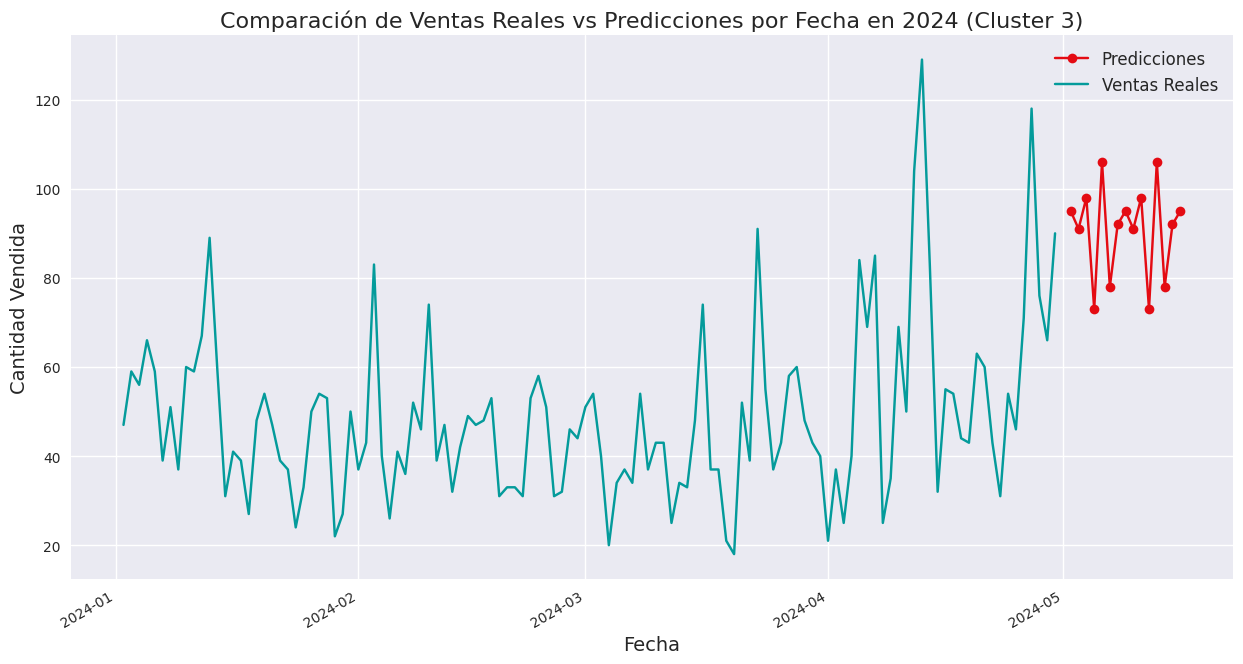

In [46]:
# Convertir la columna 'Fecha_venta' de df_merged a datetime si no lo está ya
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])
df_final_predicciones_cluster_3['Fecha_venta'] = pd.to_datetime(df_final_predicciones_cluster_3['Fecha_venta'])

# Filtrar los datos del año 2024 para el cluster 3
year_vigente = 2024
cluster_3_vigente = cluster_3[cluster_3['Fecha_venta'].dt.year == year_vigente]
predicciones_vigente_cluster_3 = df_final_predicciones_cluster_3[df_final_predicciones_cluster_3['Fecha_venta'].dt.year == year_vigente]

# Agrupar por fecha y sumar las cantidades vendidas y predichas
historicos_agrupados_cluster_3 = cluster_3_vigente.groupby('Fecha_venta')['Cant_vendidas'].sum().reset_index()
predicciones_agrupadas_cluster_3 = predicciones_vigente_cluster_3.groupby('Fecha_venta')['Cantidades predichas'].sum().reset_index()

plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predicciones_agrupadas_cluster_3['Fecha_venta'], predicciones_agrupadas_cluster_3['Cantidades predichas'], label='Predicciones', marker='o', linestyle='-', color='#e40b13')

# Gráfico de ventas reales
plt.plot(historicos_agrupados_cluster_3['Fecha_venta'], historicos_agrupados_cluster_3['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='#049b9b')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Intervalo mensual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato año-mes

plt.title('Comparación de Ventas Reales vs Predicciones por Fecha en 2024 (Cluster 3)', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('high_quality_chart_cluster_3.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()

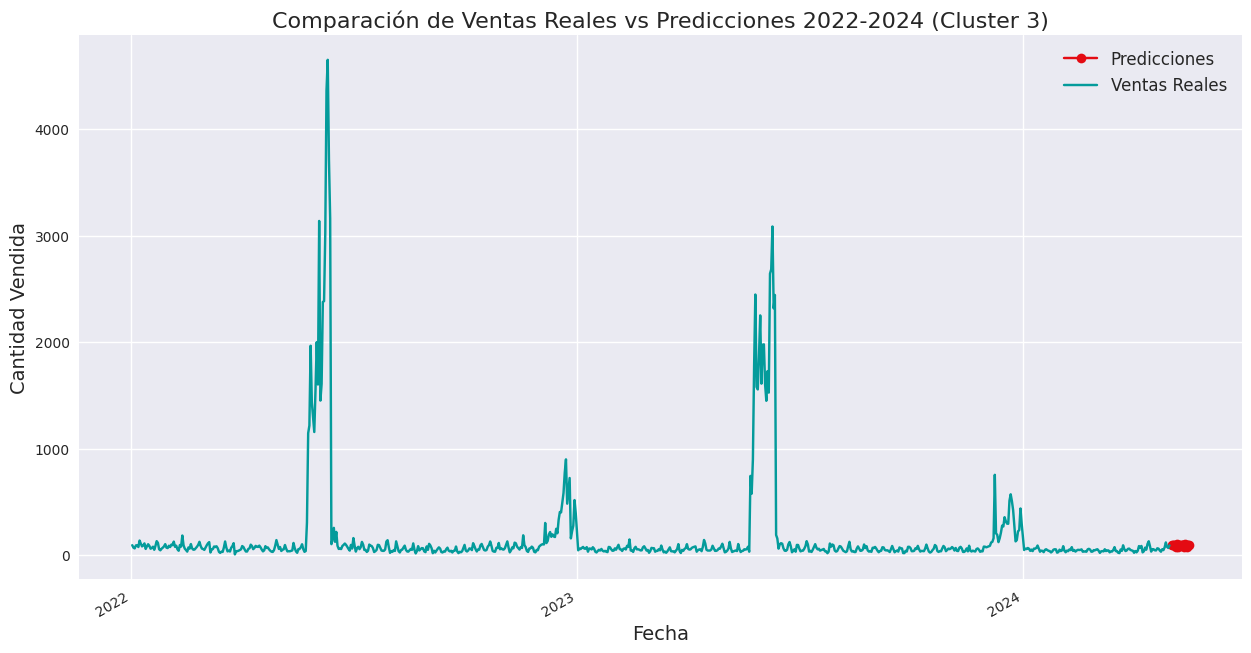

In [47]:
# Filtrar los datos desde el año 2022 hasta el 2024 para el cluster 3
start_year = 2022
end_year = 2024
mask_cluster_3 = (cluster_3['Fecha_venta'].dt.year >= start_year) & (cluster_3['Fecha_venta'].dt.year <= end_year)
cluster_3_period = cluster_3[mask_cluster_3]
mask_pred_cluster_3 = (df_final_predicciones_cluster_3['Fecha_venta'].dt.year >= start_year) & (df_final_predicciones_cluster_3['Fecha_venta'].dt.year <= end_year)
predicciones_period_cluster_3 = df_final_predicciones_cluster_3[mask_pred_cluster_3]

# Agrupar por fecha y sumar las cantidades vendidas y predichas
historicos_agrupados_cluster_3 = cluster_3_period.groupby('Fecha_venta')['Cant_vendidas'].sum().reset_index()
predicciones_agrupadas_cluster_3 = predicciones_period_cluster_3.groupby('Fecha_venta')['Cantidades predichas'].sum().reset_index()

plt.figure(figsize=(15, 8))  # Tamaño del gráfico
plt.style.use('seaborn-darkgrid')  # Estilo de fondo de cuadrícula con tema oscuro

# Gráfico de predicciones
plt.plot(predicciones_agrupadas_cluster_3['Fecha_venta'], predicciones_agrupadas_cluster_3['Cantidades predichas'], label='Predicciones', marker='o', linestyle='-', color='#e40b13')

# Gráfico de ventas reales
plt.plot(historicos_agrupados_cluster_3['Fecha_venta'], historicos_agrupados_cluster_3['Cant_vendidas'], label='Ventas Reales', marker='x', linestyle='-', color='#049b9b')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.YearLocator())  # Intervalo anual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))  # Formato año

plt.title('Comparación de Ventas Reales vs Predicciones 2022-2024 (Cluster 3)', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

plt.savefig('ventas_3_years_cluster_3.png', dpi=300)  # Guardar como imagen de alta calidad
plt.show()

##### **2.4.5  Resumen <ins>predicciones</ins>**

In [48]:
# Calcular el total de cantidades vendidas y el promedio de ventas por día para el cluster 3
total_cantidades_vendidas_cluster_3 = df_final_predicciones_cluster_3['Cantidades predichas'].sum()
promedio_ventas_por_dia_cluster_3 = df_final_predicciones_cluster_3.groupby('Fecha_venta')['Cantidades predichas'].sum().mean()

# Calcular el total de facturación y el promedio de facturación por día para el cluster 3
df_final_predicciones_cluster_3['Facturacion'] = df_final_predicciones_cluster_3['Cantidades predichas'] * df_final_predicciones_cluster_3['Precio_unidad']
total_facturacion_cluster_3 = df_final_predicciones_cluster_3['Facturacion'].sum()
promedio_facturacion_por_dia_cluster_3 = df_final_predicciones_cluster_3.groupby('Fecha_venta')['Facturacion'].sum().mean()

# Obtener el TOP 5 productos más vendidos con sus cantidades y el porcentaje sobre el total para el cluster 3
top_5_productos_cluster_3 = df_final_predicciones_cluster_3.groupby('ID_producto')['Cantidades predichas'].sum().nlargest(5)
top_5_productos_cluster_3 = top_5_productos_cluster_3.reset_index()
top_5_productos_cluster_3['Porcentaje'] = round((top_5_productos_cluster_3['Cantidades predichas'] / total_cantidades_vendidas_cluster_3) * 100, 2)

# Imprimir el resumen para el cluster 3
print("Resumen de Ventas y Facturación para Cluster 3")
print("===========================================")
print(f"Total de Cantidades Vendidas: {total_cantidades_vendidas_cluster_3}")
print(f"Promedio de Ventas por Día: {promedio_ventas_por_dia_cluster_3:.2f}")
print(f"Total de Facturación: ${total_facturacion_cluster_3:.2f}")
print(f"Promedio de Facturación por Día: ${promedio_facturacion_por_dia_cluster_3:.2f}")
print("\nTOP 5 Productos Más Vendidos:")
print(top_5_productos_cluster_3)

Resumen de Ventas y Facturación para Cluster 3
Total de Cantidades Vendidas: 1361
Promedio de Ventas por Día: 90.73
Total de Facturación: $1066239.00
Promedio de Facturación por Día: $71082.60

TOP 5 Productos Más Vendidos:
   ID_producto  Cantidades predichas  Porcentaje
0       561967                    41        3.01
1       561161                    34        2.50
2       560494                    30        2.20
3       562164                    30        2.20
4       562710                    30        2.20


# **3. <ins>Resultados Finales</ins>**

#### **3.1  Resumen <ins>general</ins>**

##### **3.1.1  Dataframes <ins>finales</ins>**

In [220]:
## DATAFRAME PREDICCIONES Y RESUEMEN DE PREDICCIONES

# Convertimos 'ID_producto' a tipo 'category' en los DataFrames de predicciones
df_final_predicciones_cluster_0['ID_producto'] = df_final_predicciones_cluster_0['ID_producto'].astype('category')
df_final_predicciones_cluster_1['ID_producto'] = df_final_predicciones_cluster_1['ID_producto'].astype('category')
df_final_predicciones_cluster_2['ID_producto'] = df_final_predicciones_cluster_2['ID_producto'].astype('category')
df_final_predicciones_cluster_3['ID_producto'] = df_final_predicciones_cluster_3['ID_producto'].astype('category')

# Convertimos 'ID_producto' a tipo 'category' en los DataFrames de resumen
df_resumen_cluster_0['ID_producto'] = df_resumen_cluster_0['ID_producto'].astype('category')
df_resumen_cluster_1['ID_producto'] = df_resumen_cluster_1['ID_producto'].astype('category')
df_resumen_cluster_2['ID_producto'] = df_resumen_cluster_2['ID_producto'].astype('category')
df_resumen_cluster_3['ID_producto'] = df_resumen_cluster_3['ID_producto'].astype('category')

# Concatenamos todos los DataFrames de predicciones y agregar la columna Cluster
df_final_predicciones_total = pd.concat([
    df_final_predicciones_cluster_0.assign(Cluster='Cluster 0'),
    df_final_predicciones_cluster_1.assign(Cluster='Cluster 1'),
    df_final_predicciones_cluster_2.assign(Cluster='Cluster 2'),
    df_final_predicciones_cluster_3.assign(Cluster='Cluster 3')
], ignore_index=True)

# Concatenamos todos los DataFrames de resumen y agregar la columna Cluster
df_resumen_total = pd.concat([
    df_resumen_cluster_0.assign(Cluster='Cluster 0'),
    df_resumen_cluster_1.assign(Cluster='Cluster 1'),
    df_resumen_cluster_2.assign(Cluster='Cluster 2'),
    df_resumen_cluster_3.assign(Cluster='Cluster 3')
], ignore_index=True)

# Ordenamos los DataFrames por la columna de cantidades vendidas en forma descendente
df_final_predicciones_total = df_final_predicciones_total.sort_values(by='Cantidades predichas', ascending=False)
df_resumen_total = df_resumen_total.sort_values(by='Cantidades_vendidas', ascending=False)

# Guardamos los DataFrames ordenados en archivos CSV
df_final_predicciones_total.to_csv('predicciones_total.csv', index=False)
df_resumen_total.to_csv('resumen_total.csv', index=False)

In [221]:
## CRUZAMIENTO DE DATOS 'ID_proveedor', 'Categoria', 'Clasif_proveedor'

# Asegurarnos de que 'ID_producto' es del tipo 'category' en todos los DataFrames
df_final_predicciones_total['ID_producto'] = df_final_predicciones_total['ID_producto'].astype('category')
df_resumen_total['ID_producto'] = df_resumen_total['ID_producto'].astype('category')

# Eliminamos duplicados en df_merged para asegurar que solo hay una fila por 'ID_producto'
df_merged_unique = df_merged.drop_duplicates(subset=['ID_producto'])

# Realizamos el merge para agregar la información a df_final_predicciones_total
df_final_predicciones_total_completo = df_final_predicciones_total.merge(
    df_merged_unique[['ID_producto', 'ID_proveedor', 'Categoria', 'Clasif_proveedor']],
    on='ID_producto',
    how='left'
)

# Realizamos el merge para agregar la información a df_resumen_total
df_resumen_total_completo = df_resumen_total.merge(
    df_merged_unique[['ID_producto', 'ID_proveedor', 'Categoria', 'Clasif_proveedor']],
    on='ID_producto',
    how='left'
)

# Guardamos los DataFrames resultantes en los archivos CSV originales
df_final_predicciones_total_completo.to_csv('predicciones_total.csv', index=False)
df_resumen_total_completo.to_csv('resumen_total.csv', index=False)

In [229]:
# Asegurarnos de que 'ID_producto' es del tipo 'category' en todos los DataFrames
df_final_predicciones_total['ID_producto'] = df_final_predicciones_total['ID_producto'].astype('category')
df_resumen_total['ID_producto'] = df_resumen_total['ID_producto'].astype('category')

# Eliminamos duplicados en df_merged para asegurar que solo hay una fila por 'ID_producto'
df_merged_unique = df_merged.drop_duplicates(subset=['ID_producto'])

# Realizamos el merge para agregar la información a df_final_predicciones_total
df_final_predicciones_total_completo = df_final_predicciones_total.merge(
    df_merged_unique[['ID_producto', 'ID_proveedor', 'Categoria', 'Clasif_proveedor']],
    on='ID_producto',
    how='left'
)

# Realizamos el merge para agregar la información a df_resumen_total
df_resumen_total_completo = df_resumen_total.merge(
    df_merged_unique[['ID_producto', 'ID_proveedor', 'Categoria', 'Clasif_proveedor']],
    on='ID_producto',
    how='left'
)

# Guardamos los DataFrames resultantes en los archivos CSV originales
df_final_predicciones_total_completo.to_csv('predicciones_total.csv', index=False)
df_resumen_total_completo.to_csv('resumen_total.csv', index=False)

# Llenar valores faltantes en 'ID_proveedor' con un valor específico, por ejemplo, -1, y luego convertir a entero
df_resumen_total_completo['ID_proveedor'] = df_resumen_total_completo['ID_proveedor'].fillna(-1).astype(int)

# Convertir 'ID_proveedor' a tipo 'category' después de manejar NaN
df_resumen_total_completo['ID_proveedor'] = df_resumen_total_completo['ID_proveedor'].astype('category')

# Agrupar por 'ID_proveedor' y calcular las cantidades totales
df_resumen_proveedor = df_resumen_total_completo.groupby('ID_proveedor').agg(
    Cantidad_Total=('Cantidades_vendidas', 'sum')  # Usar sum en lugar de count para totalizar las cantidades vendidas correctamente
).reset_index()

# Ordenar el DataFrame resultante por 'Cantidad_Total' en orden descendente
df_resumen_proveedor_sorted = df_resumen_proveedor.sort_values(by='Cantidad_Total', ascending=False)

# Guardar el DataFrame resultante en un archivo CSV
df_resumen_proveedor_sorted.to_csv('resumen_proveedores.csv', index=False)

##### **3.2.1  <ins>Estadísticos Finales</ins>**

In [223]:
## ESTADÍSTICAS PREDICCIONES

# Calculamos el total de cantidades vendidas y facturación para cada cluster
total_cantidades_vendidas_cluster_0 = df_final_predicciones_cluster_0['Cantidades predichas'].sum()
total_cantidades_vendidas_cluster_1 = df_final_predicciones_cluster_1['Cantidades predichas'].sum()
total_cantidades_vendidas_cluster_2 = df_final_predicciones_cluster_2['Cantidades predichas'].sum()
total_cantidades_vendidas_cluster_3 = df_final_predicciones_cluster_3['Cantidades predichas'].sum()

total_facturacion_cluster_0 = (df_final_predicciones_cluster_0['Cantidades predichas'] * df_final_predicciones_cluster_0['Precio_unidad']).sum()
total_facturacion_cluster_1 = (df_final_predicciones_cluster_1['Cantidades predichas'] * df_final_predicciones_cluster_1['Precio_unidad']).sum()
total_facturacion_cluster_2 = (df_final_predicciones_cluster_2['Cantidades predichas'] * df_final_predicciones_cluster_2['Precio_unidad']).sum()
total_facturacion_cluster_3 = (df_final_predicciones_cluster_3['Cantidades predichas'] * df_final_predicciones_cluster_3['Precio_unidad']).sum()

# Calculamos totales globales
total_cantidades_vendidas_global = (total_cantidades_vendidas_cluster_0 + 
                                    total_cantidades_vendidas_cluster_1 + 
                                    total_cantidades_vendidas_cluster_2 + 
                                    total_cantidades_vendidas_cluster_3)

total_facturacion_global = (total_facturacion_cluster_0 + 
                            total_facturacion_cluster_1 + 
                            total_facturacion_cluster_2 + 
                            total_facturacion_cluster_3)

# Imprimimos la contribución de cada cluster
print("Contribución de Cada Cluster a las Ventas Totales")
print("===================================================")
print(f"Cluster 0 - Cantidades Vendidas: {total_cantidades_vendidas_cluster_0} ({total_cantidades_vendidas_cluster_0 / total_cantidades_vendidas_global * 100:.2f}%)")
print(f"Cluster 0 - Facturación: ${total_facturacion_cluster_0:.2f} ({total_facturacion_cluster_0 / total_facturacion_global * 100:.2f}%)")

print(f"Cluster 1 - Cantidades Vendidas: {total_cantidades_vendidas_cluster_1} ({total_cantidades_vendidas_cluster_1 / total_cantidades_vendidas_global * 100:.2f}%)")
print(f"Cluster 1 - Facturación: ${total_facturacion_cluster_1:.2f} ({total_facturacion_cluster_1 / total_facturacion_global * 100:.2f}%)")

print(f"Cluster 2 - Cantidades Vendidas: {total_cantidades_vendidas_cluster_2} ({total_cantidades_vendidas_cluster_2 / total_cantidades_vendidas_global * 100:.2f}%)")
print(f"Cluster 2 - Facturación: ${total_facturacion_cluster_2:.2f} ({total_facturacion_cluster_2 / total_facturacion_global * 100:.2f}%)")

print(f"Cluster 3 - Cantidades Vendidas: {total_cantidades_vendidas_cluster_3} ({total_cantidades_vendidas_cluster_3 / total_cantidades_vendidas_global * 100:.2f}%)")
print(f"Cluster 3 - Facturación: ${total_facturacion_cluster_3:.2f} ({total_facturacion_cluster_3 / total_facturacion_global * 100:.2f}%)")

# Calculamos el total de cantidades vendidas y el promedio de ventas por día para todos los clusters
total_cantidades_vendidas_todos_clusters = df_final_predicciones_total['Cantidades predichas'].sum()
promedio_ventas_por_dia_todos_clusters = df_final_predicciones_total.groupby('Fecha_venta')['Cantidades predichas'].sum().mean()

# Calculamos el total de facturación y el promedio de facturación por día para todos los clusters
df_final_predicciones_total['Facturacion'] = df_final_predicciones_total['Cantidades predichas'] * df_final_predicciones_total['Precio_unidad']
total_facturacion_todos_clusters = df_final_predicciones_total['Facturacion'].sum()
promedio_facturacion_por_dia_todos_clusters = df_final_predicciones_total.groupby('Fecha_venta')['Facturacion'].sum().mean()

# Obtenemos el TOP 5 productos más vendidos con sus cantidades y el porcentaje sobre el total para todos los clusters
top_5_productos_todos_clusters = df_final_predicciones_total.groupby('ID_producto')['Cantidades predichas'].sum().nlargest(5)
top_5_productos_todos_clusters = top_5_productos_todos_clusters.reset_index()
top_5_productos_todos_clusters['Porcentaje'] = round((top_5_productos_todos_clusters['Cantidades predichas'] / total_cantidades_vendidas_todos_clusters) * 100, 2)

# Imprimimos el resumen para todos los clusters
print("\nResumen de Ventas y Facturación para Todos los Clusters")
print("=======================================================")
print(f"Total de Cantidades Vendidas: {total_cantidades_vendidas_todos_clusters}")
print(f"Promedio de Ventas por Día: {promedio_ventas_por_dia_todos_clusters:.2f}")
print(f"Total de Facturación: ${total_facturacion_todos_clusters:.2f}")
print(f"Promedio de Facturación por Día: ${promedio_facturacion_por_dia_todos_clusters:.2f}")
print("\nTOP 5 Productos Más Vendidos:")
print(top_5_productos_todos_clusters)


Contribución de Cada Cluster a las Ventas Totales
Cluster 0 - Cantidades Vendidas: 2768 (57.44%)
Cluster 0 - Facturación: $1884186.00 (54.66%)
Cluster 1 - Cantidades Vendidas: 687 (14.26%)
Cluster 1 - Facturación: $432224.00 (12.54%)
Cluster 2 - Cantidades Vendidas: 3 (0.06%)
Cluster 2 - Facturación: $64715.00 (1.88%)
Cluster 3 - Cantidades Vendidas: 1361 (28.24%)
Cluster 3 - Facturación: $1066239.00 (30.93%)

Resumen de Ventas y Facturación para Todos los Clusters
Total de Cantidades Vendidas: 4819
Promedio de Ventas por Día: 321.27
Total de Facturación: $3447364.00
Promedio de Facturación por Día: $229824.27

TOP 5 Productos Más Vendidos:
  ID_producto  Cantidades predichas  Porcentaje
0      561636                   113        2.34
1      560032                   104        2.16
2      561278                    87        1.81
3      561395                    81        1.68
4      560978                    66        1.37


In [230]:
## OTROS ESTADÍSTICOS

import pandas as pd

# Asegúrate de que 'Fecha_venta' es del tipo datetime
df_final_predicciones_total_completo['Fecha_venta'] = pd.to_datetime(df_final_predicciones_total_completo['Fecha_venta'])

# Día con la mayor y menor cantidad de ventas
ventas_por_dia = df_final_predicciones_total_completo.groupby('Fecha_venta')['Cantidades predichas'].sum()
dia_mayor_ventas = ventas_por_dia.idxmax()
mayor_ventas = ventas_por_dia.max()
dia_menor_ventas = ventas_por_dia.idxmin()
menor_ventas = ventas_por_dia.min()

# Cantidad de ventas de vinos finos y espumantes
vinos_finos_ventas = df_final_predicciones_total_completo[df_final_predicciones_total_completo['Categoria'] == 216]['Cantidades predichas'].sum()
espumantes_ventas = df_final_predicciones_total_completo[df_final_predicciones_total_completo['Categoria'] == 217]['Cantidades predichas'].sum()

# TOP 5 proveedores con más ventas
top_5_proveedores = df_resumen_proveedor_sorted.head(5)

# Imprimir resultados usando strftime para formatear la fecha
print("Día con la mayor cantidad de ventas:", dia_mayor_ventas.strftime('%Y-%m-%d'), "con", mayor_ventas, "ventas")
print("Día con la menor cantidad de ventas:", dia_menor_ventas.strftime('%Y-%m-%d'), "con", menor_ventas, "ventas")
print("\nTop 5 Proveedores con más ventas:")
print(top_5_proveedores)

Día con la mayor cantidad de ventas: 2024-05-05 con 623 ventas
Día con la menor cantidad de ventas: 2024-05-12 con 121 ventas

Top 5 Proveedores con más ventas:
   ID_proveedor  Cantidad_Total
21        22049             773
2         10214             572
32        31066             244
22        22231             237
25        25161             220


##### **3.3.1  <ins>Evolución y predicciones</ins>**

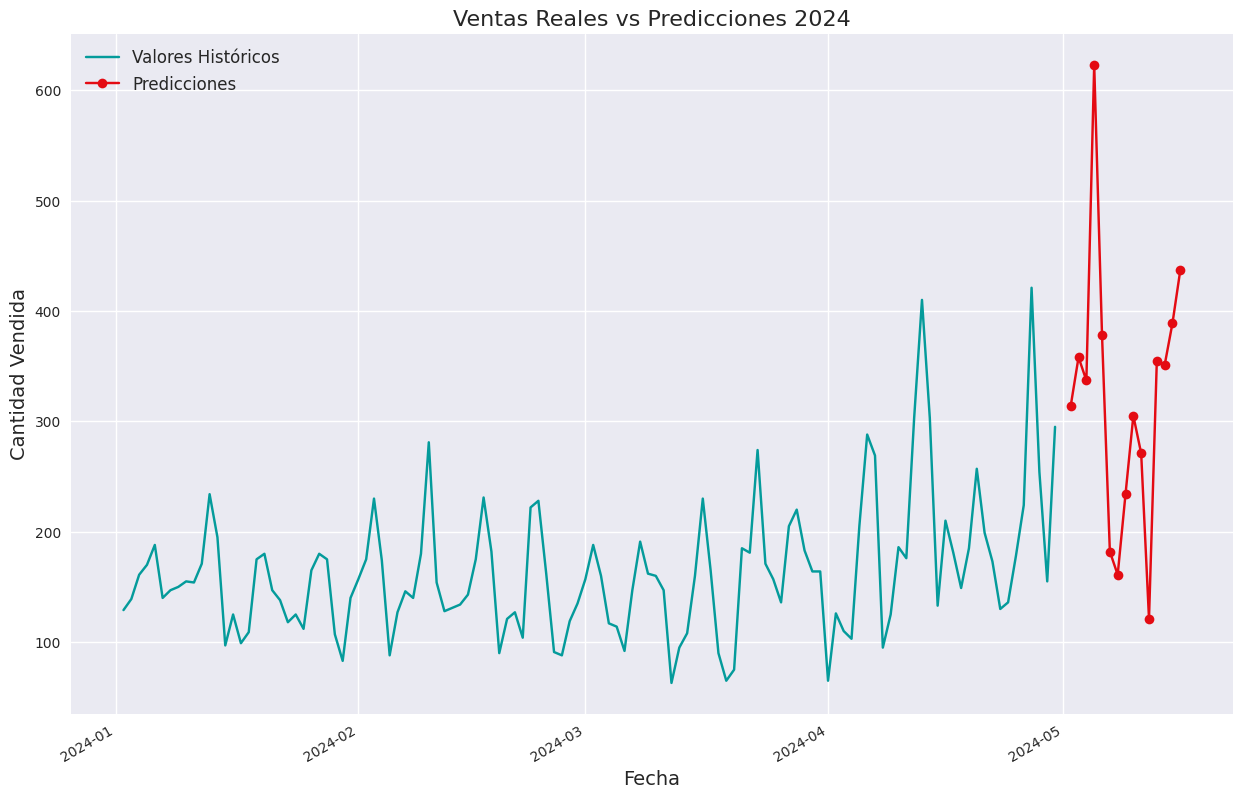

In [213]:
# Convertir 'Fecha_venta' a datetime en todos los DataFrames
df_merged['Fecha_venta'] = pd.to_datetime(df_merged['Fecha_venta'])
df_final_predicciones_cluster_0['Fecha_venta'] = pd.to_datetime(df_final_predicciones_cluster_0['Fecha_venta'])
df_final_predicciones_cluster_1['Fecha_venta'] = pd.to_datetime(df_final_predicciones_cluster_1['Fecha_venta'])
df_final_predicciones_cluster_3['Fecha_venta'] = pd.to_datetime(df_final_predicciones_cluster_3['Fecha_venta'])

# Filtrar los datos desde el año 2024 y que las cantidades vendidas sean mayores o iguales a cero
historicos_2024 = df_merged[(df_merged['Fecha_venta'].dt.year >= 2024) & (df_merged['Cant_vendidas'] >= 0)]

# Agrupar por fecha y sumar las cantidades vendidas
historicos_agrupados_2024 = historicos_2024.groupby('Fecha_venta')['Cant_vendidas'].sum().reset_index()

# Filtrar las predicciones del año 2024
predicciones_vigente_cluster_0 = df_final_predicciones_cluster_0[df_final_predicciones_cluster_0['Fecha_venta'].dt.year >= 2024]
predicciones_vigente_cluster_1 = df_final_predicciones_cluster_1[df_final_predicciones_cluster_1['Fecha_venta'].dt.year >= 2024]
predicciones_vigente_cluster_3 = df_final_predicciones_cluster_3[df_final_predicciones_cluster_3['Fecha_venta'].dt.year >= 2024]

# Concatenar las predicciones de todos los clusters
predicciones_total = pd.concat([predicciones_vigente_cluster_0, predicciones_vigente_cluster_1, predicciones_vigente_cluster_3])

# Agrupar por fecha y sumar las cantidades predichas
predicciones_agrupadas_total = predicciones_total.groupby('Fecha_venta')['Cantidades predichas'].sum().reset_index()

# Configurar el tamaño del gráfico y el estilo de fondo
plt.figure(figsize=(15, 10))
plt.style.use('seaborn-darkgrid')

# Graficar datos históricos
plt.plot(historicos_agrupados_2024['Fecha_venta'], historicos_agrupados_2024['Cant_vendidas'], label='Valores Históricos', marker='x', linestyle='-', color='#049b9b')

# Graficar datos de predicciones
plt.plot(predicciones_agrupadas_total['Fecha_venta'], predicciones_agrupadas_total['Cantidades predichas'], label='Predicciones', marker='o', linestyle='-', color='#e40b13')

# Configuración de los formatos de fecha en el eje X
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))  # Intervalo mensual
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # Formato año-mes

plt.title('Ventas Reales vs Predicciones 2024', fontsize=16)
plt.xlabel('Fecha', fontsize=14)
plt.ylabel('Cantidad Vendida', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Mejorar la rotación y alineación de las etiquetas de fecha
plt.gcf().autofmt_xdate()

# Guardar como imagen de alta calidad
plt.savefig('comparacion_ventas_predicciones_2024.png', dpi=300)

# Mostrar el gráfico
plt.show()

#### **3.2 <ins>Virtudes</ins> y <ins>Limitaciones</ins>**

## **Virtudes**
 Cada cluster identificado cuenta con un modelo específico que se adapta a su características.
 
 
A través de un input es posible determinar el intervalo de 15 días que se desea predecir, especificando si hay o no productos en promoción y, en caso de haberlos, cuáles son estos (pudiendo ser la totalidad o simplemente un grupo de ello.
 


Modelo permite conocer tanto la predicción diaria de las cantidades vendidas, precio y facturación de cada producto también los requerimientos de unidades que se requieren de cada proveedor.


## **Limitaciones**

Problema con la predicción en Cluster 0 para días específicos. 

Los modelos planteados presentan inexactitudes a largo plazo (más allá de los 100 días). Esto como consecuencia de la formulación de modelos con R2 alto que buscan resultados más exactos en el corto plazo.


Clusterización basada en las cantidades vendidas y en facturación, lo cual puede no suponer la mejor forma de agrupamiento de productos. Esto está limitado a la escasa información sobre la característica de los produc.

oductos.or.
